In [1]:
# Cell 1
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import io
import os
from sklearn.preprocessing import MinMaxScaler
from tqdm import tqdm
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
import random
from keras.models import Sequential
from keras.layers import LSTM, Dense
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
from tensorflow.keras.models import load_model
from keras.utils import custom_object_scope

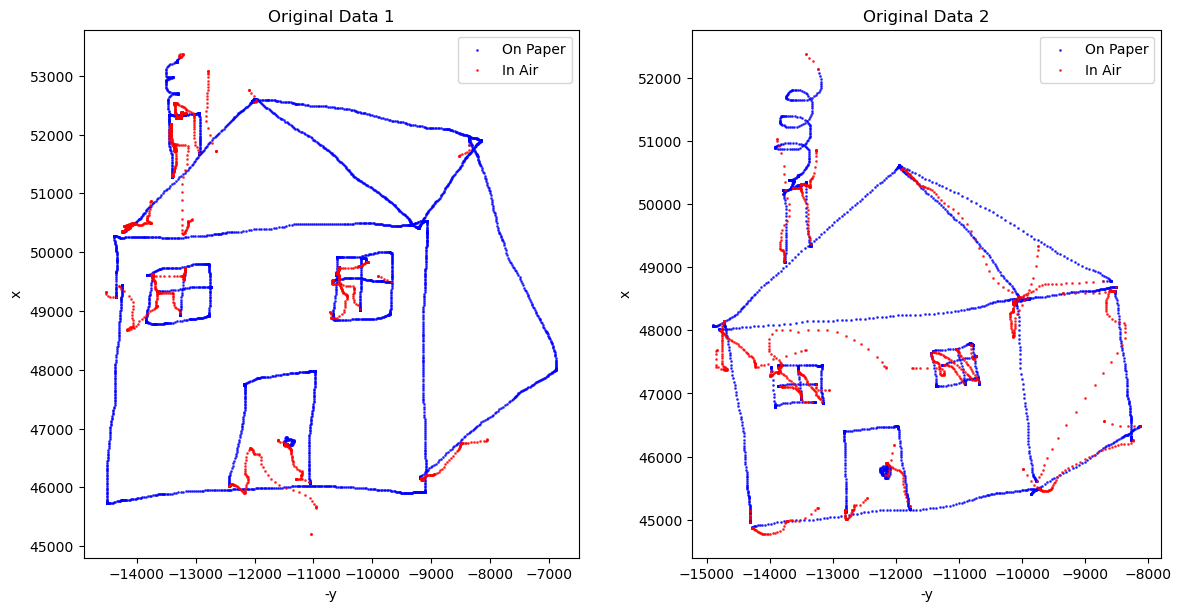

Number of processed files: 2
Average number of data points: 4387


In [123]:
# Cell 2
# Updated function
# Updated function without saving data inside
def upload_and_process_files(directory, num_files_to_use=None):
    svc_files = [f for f in os.listdir(directory) if f.endswith('.svc')]
    
    # If num_files_to_use is specified, only take that many files sequentially
    if num_files_to_use:
        svc_files = svc_files[:num_files_to_use]  # Take the first num_files_to_use files

    data_frames = []  # Processed data after scaling
    original_data_frames = []  # Save the original unscaled data
    scalers = []
    input_filenames = []  # List to store input filenames

    num_files = len(svc_files)
    fig, axs = plt.subplots(1, num_files, figsize=(6*num_files, 6), constrained_layout=True)
    if num_files == 1:
        axs = [axs]

    for i, filename in enumerate(svc_files):
        file_path = os.path.join(directory, filename)
        input_filenames.append(filename)  # Store the filename
        df = pd.read_csv(file_path, skiprows=1, header=None, delim_whitespace=True)
        df.columns = ['x', 'y', 'timestamp', 'pen_status', 'pressure', 'azimuth', 'altitude']
        
        # Modify timestamp to start from 0
        df['timestamp'] = (df['timestamp'] - df['timestamp'].min()).round().astype(int)
        
        # Keep a copy of the original data before scaling
        original_data_frames.append(df.copy())  # Save the original unmodified data
        
        # Process the data for use in the model
        df = df.iloc[:, [0, 1, 2, 3, 4, 5, 6]] 
        data_frames.append(df)
        scaler = MinMaxScaler()
        normalized_data = scaler.fit_transform(df[['x', 'y', 'timestamp']])
        scalers.append(scaler)

        on_paper = df[df['pen_status'] == 1]
        in_air = df[df['pen_status'] == 0]
        axs[i].scatter(-on_paper['y'], on_paper['x'], c='blue', s=1, alpha=0.7, label='On Paper')
        axs[i].scatter(-in_air['y'], in_air['x'], c='red', s=1, alpha=0.7, label='In Air')
        axs[i].set_title(f'Original Data {i + 1}')
        axs[i].set_xlabel('-y')
        axs[i].set_ylabel('x')
        axs[i].legend()
        axs[i].set_aspect('equal')

    plt.show()

    processed_data = [np.column_stack((scaler.transform(df[['x', 'y', 'timestamp']]), df['pen_status'].values)) 
                      for df, scaler in zip(data_frames, scalers)]
    avg_data_points = int(np.mean([df.shape[0] for df in data_frames]))

    return data_frames, processed_data, scalers, avg_data_points, input_filenames, original_data_frames  # Return original data

# Save data outside the function
def save_original_data(data_frames, input_filenames, output_folder='original_absolute'):
    os.makedirs(output_folder, exist_ok=True)
    for df, filename in zip(data_frames, input_filenames):
        save_path = os.path.join(output_folder, filename)
        df.to_csv(save_path, sep=' ', index=False, header=False)

directory = 'Task2'  # Directory where the .svc files are stored
num_files_to_use = 2
data_frames, processed_data, scalers, avg_data_points, input_filenames, original_data_frames = upload_and_process_files(directory, num_files_to_use)

# Save the original data after processing
save_original_data(original_data_frames, input_filenames)

# Store the name of the first file for use in Cell 4
input_filename = input_filenames[0] if input_filenames else 'processed_data'
print(f"Number of processed files: {len(processed_data)}")
print(f"Average number of data points: {avg_data_points}")


In [124]:
# Cell 3
# Process each DataFrame instead of just the first one
for df_idx in range(len(data_frames)):
    df = data_frames[df_idx]  # Using each DataFrame in the list

    # Convert the 'timestamp' column to numeric for calculations (if not already done)
    df['timestamp'] = pd.to_numeric(df['timestamp'])

    # Sort the DataFrame by timestamp (should already be sorted in the function)
    df.sort_values('timestamp', inplace=True)

    # Calculate the differences between consecutive timestamps (optional for gap finding)
    df['time_diff'] = df['timestamp'].diff()

    # Identify the indices where the time difference is greater than 30,000 milliseconds
    gap_indices = df.index[df['time_diff'] > 8].tolist()

    # Create an empty list to hold the new rows
    new_rows = []

    # Fill in the gaps with 70 milliseconds intervals
    for idx in gap_indices:
        # Check if the next index is valid
        if idx + 1 < len(df):
            # Get the current and next timestamps
            current_timestamp = df.at[idx, 'timestamp']
            next_timestamp = df.at[idx + 1, 'timestamp']

            # Calculate how many entries we need to fill in
            num_fill_entries = (next_timestamp - current_timestamp) // 7

            # Generate the timestamps to fill the gap
            for i in range(1, num_fill_entries + 1):
                new_timestamp = current_timestamp + i * 7

                # Create a new row to fill in with NaN for x and y
                new_row = {
                    'x': np.nan,  # Set x to NaN
                    'y': np.nan,  # Set y to NaN
                    'timestamp': new_timestamp,
                    'pen_status': 0,        # You can set this to your desired value
                    'azimuth': df.at[idx, 'azimuth'],   # Use the current azimuth value
                    'altitude': df.at[idx, 'altitude'], # Use the current altitude value
                    'pressure': df.at[idx, 'pressure']  # Use the current pressure value
                }

                # Append the new row to the list of new rows
                new_rows.append(new_row)

    # Create a DataFrame from the new rows
    new_rows_df = pd.DataFrame(new_rows)

    # Concatenate the original DataFrame with the new rows DataFrame
    df = pd.concat([df, new_rows_df], ignore_index=True)

    # Sort the DataFrame by timestamp to maintain order
    df.sort_values('timestamp', inplace=True)

    # Reset index after sorting
    df.reset_index(drop=True, inplace=True)


    # Check for NaN entries before interpolation
    if df[['x', 'y']].isnull().any().any():
        df[['x', 'y']] = df[['x', 'y']].interpolate(method='linear')

    # Drop the 'time_diff' column after processing
    df.drop(columns=['time_diff'], inplace=True)

    # Update the processed data
    data_frames[df_idx] = df

# Update processed data for all DataFrames
processed_data = [np.column_stack((scaler.transform(df[['x', 'y', 'timestamp']]), df['pen_status'].values)) 
                  for df, scaler in zip(data_frames, scalers)]
avg_data_points = int(np.mean([df.shape[0] for df in data_frames]))

In [125]:

# Cell 4
##### Start
# Create the 'imputed' folder if it doesn't exist
imputed_folder = 'imputed'
os.makedirs(imputed_folder, exist_ok=True)
##### End
processed_dataframes = []

for input_filename, df in zip(input_filenames, data_frames):
    # Convert all numeric columns to integers
    df[['x', 'y', 'timestamp', 'pen_status', 'pressure', 'azimuth', 'altitude']] = df[['x', 'y', 'timestamp', 'pen_status', 'pressure', 'azimuth', 'altitude']].astype(int)

    #########Start
    # Save the processed DataFrame to the 'imputed' folder with the same input filename
    save_path = os.path.join(imputed_folder, input_filename)
    df.to_csv(save_path, sep=' ', index=False, header=False)  # Save without header and index
    ##########Emd
    # Append the processed DataFrame to the list
    processed_dataframes.append(df)

    print(f"Processed DataFrame saved as: {input_filename}")

Processed DataFrame saved as: u00001s00001_hw00002.svc
Processed DataFrame saved as: u00002s00001_hw00002.svc


In [126]:
# Cell 5 (modified)
def process_dataframes(dataframes, num_files_to_use=None):
    if num_files_to_use:
        dataframes = dataframes[:num_files_to_use]

    data_frames = []
    scalers = []

    for i, df in enumerate(dataframes):
        # Modify timestamp to start from 0
        df['timestamp'] = (df['timestamp'] - df['timestamp'].min()).round().astype(int)
        
        data_frames.append(df)
        scaler = MinMaxScaler()
        scaler.fit(df[['x', 'y', 'timestamp']])  # Fit the scaler
        scalers.append(scaler)

        # Print the first few rows of the timestamp column
        # print(f"Modified timestamps for DataFrame {i + 1}:")
        # print(df['timestamp'].head())
        # print("\n")

    processed_data = [np.column_stack((scaler.transform(df[['x', 'y', 'timestamp']]), df['pen_status'].values)) 
                      for df, scaler in zip(data_frames, scalers)]
    avg_data_points = int(np.mean([df.shape[0] for df in data_frames]))

    return data_frames, processed_data, scalers, avg_data_points, [f"DataFrame_{i+1}" for i in range(len(dataframes))]

# Use the processed_dataframes directly 
data_frames, processed_data, scalers, avg_data_points, original_filenames = process_dataframes(processed_dataframes, num_files_to_use)
print(f"Number of processed files: {len(processed_data)}")
print(f"Average number of data points: {avg_data_points}")

Number of processed files: 2
Average number of data points: 4681


In [127]:
# Cell 6 (modified)
class VAE(tf.keras.Model):
    def __init__(self, latent_dim, beta=1.0, lambda_shift=0.01, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.latent_dim = latent_dim
        self.beta = beta
        self.lambda_shift = lambda_shift
        self.encoder = tf.keras.Sequential([
            tf.keras.layers.InputLayer(input_shape=(4,)),
            tf.keras.layers.Dense(128, activation='relu'),
            tf.keras.layers.Dense(64, activation='relu'),
            tf.keras.layers.Dense(32, activation='relu'),
            tf.keras.layers.Dense(latent_dim * 2)
        ])
        self.decoder = tf.keras.Sequential([
            tf.keras.layers.InputLayer(input_shape=(latent_dim,)),
            tf.keras.layers.Dense(32, activation='relu'),
            tf.keras.layers.Dense(64, activation='relu'),
            tf.keras.layers.Dense(128, activation='relu'),
            tf.keras.layers.Dense(4)
        ])

    def encode(self, x):
        mean, logvar = tf.split(self.encoder(x), num_or_size_splits=2, axis=1)
        return mean, logvar

    def reparameterize(self, mean, logvar):
        eps = tf.random.normal(shape=mean.shape)
        # Apply shift correction
        return eps * tf.exp(logvar * .5) + (mean + self.lambda_shift * tf.exp(logvar * .5))

    def decode(self, z):
        decoded = self.decoder(z)
        xy_timestamp = tf.sigmoid(decoded[:, :3])
        pen_status = tf.sigmoid(decoded[:, 3])
        return tf.concat([xy_timestamp, tf.expand_dims(pen_status, -1)], axis=1)

    def call(self, inputs):
        mean, logvar = self.encode(inputs)
        z = self.reparameterize(mean, logvar)
        return self.decode(z), mean, logvar

    @classmethod
    def from_config(cls, config):
        config.pop('trainable', None)
        config.pop('dtype', None)
        return cls(**config)

    def get_config(self):
        config = super(VAE, self).get_config()
        config.update({
            'latent_dim': self.latent_dim,
            'beta': self.beta,
            'lambda_shift': self.lambda_shift
        })
        return config


# New: LSTM Discriminator for GAN
class LSTMDiscriminator(tf.keras.Model):
    def __init__(self):
        super(LSTMDiscriminator, self).__init__()
        self.model = Sequential()
        self.model.add(LSTM(64, return_sequences=True, input_shape=(None, 4)))  # LSTM for sequence learning
        self.model.add(LSTM(32))
        self.model.add(Dense(1, activation='sigmoid'))  # Binary classification

    def call(self, x):
        return self.model(x)


# Function to compute VAE loss
def compute_loss(model, x):
    x_reconstructed, mean, logvar = model(x)
    reconstruction_loss_xy_timestamp = tf.reduce_mean(tf.keras.losses.mse(x[:, :3], x_reconstructed[:, :3]))
    reconstruction_loss_pen = tf.reduce_mean(tf.keras.losses.binary_crossentropy(x[:, 3], x_reconstructed[:, 3]))
    kl_loss = -0.5 * tf.reduce_mean(1 + logvar - tf.square(mean) - tf.exp(logvar))
    return reconstruction_loss_xy_timestamp + reconstruction_loss_pen, kl_loss, model.beta * kl_loss


# Parameters for VAE
latent_dim = 128
beta = 0.001
learning_rate = 0.001
lambda_shift = 0.5

vae = VAE(latent_dim, beta, lambda_shift)
optimizer = tf.keras.optimizers.Adam(learning_rate)


c:\Users\katod\anaconda3\Lib\site-packages\keras\src\layers\core\input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


In [128]:
# Cell 7 (modified)
def generate_augmented_data(model, num_augmented_files, avg_data_points, processed_data, base_latent_variability=1.0, latent_variability_range=(0.5, 2.0)):
    augmented_datasets = []
    num_input_files = len(processed_data)
    
    for i in range(num_augmented_files):
        selected_data = processed_data[i % num_input_files]
        original_data = data_frames[i % num_input_files]
        pressure_azimuth_altitude = original_data[['pressure', 'azimuth', 'altitude']].values
        
        latent_variability = base_latent_variability * np.random.uniform(latent_variability_range[0], latent_variability_range[1])
        
        mean, logvar = model.encode(tf.convert_to_tensor(selected_data, dtype=tf.float32))
        z = model.reparameterize(mean, logvar * latent_variability)
        
        augmented_data = model.decode(z).numpy()

        augmented_data[:, 3] = post_process_pen_status(augmented_data[:, 3])
        augmented_data[:, 2] = np.sort(augmented_data[:, 2])
        augmented_data = np.column_stack((augmented_data, pressure_azimuth_altitude[:augmented_data.shape[0]]))
        
        augmented_datasets.append(augmented_data)

    return augmented_datasets

# The post_process_pen_status function remains unchanged
def post_process_pen_status(pen_status, threshold=0.5, min_segment_length=5):
    binary_pen_status = (pen_status > threshold).astype(int)
    
    # Smooth out rapid changes
    for i in range(len(binary_pen_status) - min_segment_length):
        if np.all(binary_pen_status[i:i+min_segment_length] == binary_pen_status[i]):
            binary_pen_status[i:i+min_segment_length] = binary_pen_status[i]
    
    return binary_pen_status

c:\Users\katod\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
Epoch 1/100: 100%|██████████| 27/27 [00:29<00:00,  1.08s/batch, Generator Loss=0.85, Reconstruction Loss=0.85, KL Loss=0.00326]  


Epoch 1: Generator Loss = 0.805619, Reconstruction Loss = 0.805619, KL Divergence Loss = 0.003202


Epoch 2/100: 100%|██████████| 27/27 [00:01<00:00, 25.31batch/s, Generator Loss=0.714, Reconstruction Loss=0.714, KL Loss=0.057] 


Epoch 2: Generator Loss = 0.723441, Reconstruction Loss = 0.723441, KL Divergence Loss = 0.035430


Epoch 3/100: 100%|██████████| 27/27 [00:01<00:00, 17.23batch/s, Generator Loss=0.102, Reconstruction Loss=0.102, KL Loss=0.198]  


Epoch 3: Generator Loss = 0.143717, Reconstruction Loss = 0.143717, KL Divergence Loss = 0.433850


Epoch 4/100: 100%|██████████| 27/27 [00:01<00:00, 21.92batch/s, Generator Loss=0.0693, Reconstruction Loss=0.0693, KL Loss=0.594]


Epoch 4: Generator Loss = 0.079291, Reconstruction Loss = 0.079291, KL Divergence Loss = 0.680914


Epoch 5/100: 100%|██████████| 27/27 [00:01<00:00, 16.06batch/s, Generator Loss=0.0837, Reconstruction Loss=0.0837, KL Loss=0.412]


Epoch 5: Generator Loss = 0.067590, Reconstruction Loss = 0.067590, KL Divergence Loss = 0.631677


Epoch 6/100: 100%|██████████| 27/27 [00:01<00:00, 24.07batch/s, Generator Loss=0.0814, Reconstruction Loss=0.0814, KL Loss=0.52] 


Epoch 6: Generator Loss = 0.060742, Reconstruction Loss = 0.060742, KL Divergence Loss = 0.685082


Epoch 7/100: 100%|██████████| 27/27 [00:01<00:00, 19.04batch/s, Generator Loss=0.039, Reconstruction Loss=0.039, KL Loss=0.679]  


Epoch 7: Generator Loss = 0.055586, Reconstruction Loss = 0.055585, KL Divergence Loss = 0.782007


Epoch 8/100: 100%|██████████| 27/27 [00:02<00:00, 11.58batch/s, Generator Loss=0.0519, Reconstruction Loss=0.0519, KL Loss=0.673]


Epoch 8: Generator Loss = 0.056432, Reconstruction Loss = 0.056431, KL Divergence Loss = 0.779038


Epoch 9/100: 100%|██████████| 27/27 [00:02<00:00, 10.64batch/s, Generator Loss=0.0442, Reconstruction Loss=0.0442, KL Loss=0.588]


Epoch 9: Generator Loss = 0.058086, Reconstruction Loss = 0.058085, KL Divergence Loss = 0.741816


Epoch 10/100: 100%|██████████| 27/27 [00:01<00:00, 15.70batch/s, Generator Loss=0.0733, Reconstruction Loss=0.0733, KL Loss=0.613]


Epoch 10: Generator Loss = 0.058987, Reconstruction Loss = 0.058986, KL Divergence Loss = 0.726949


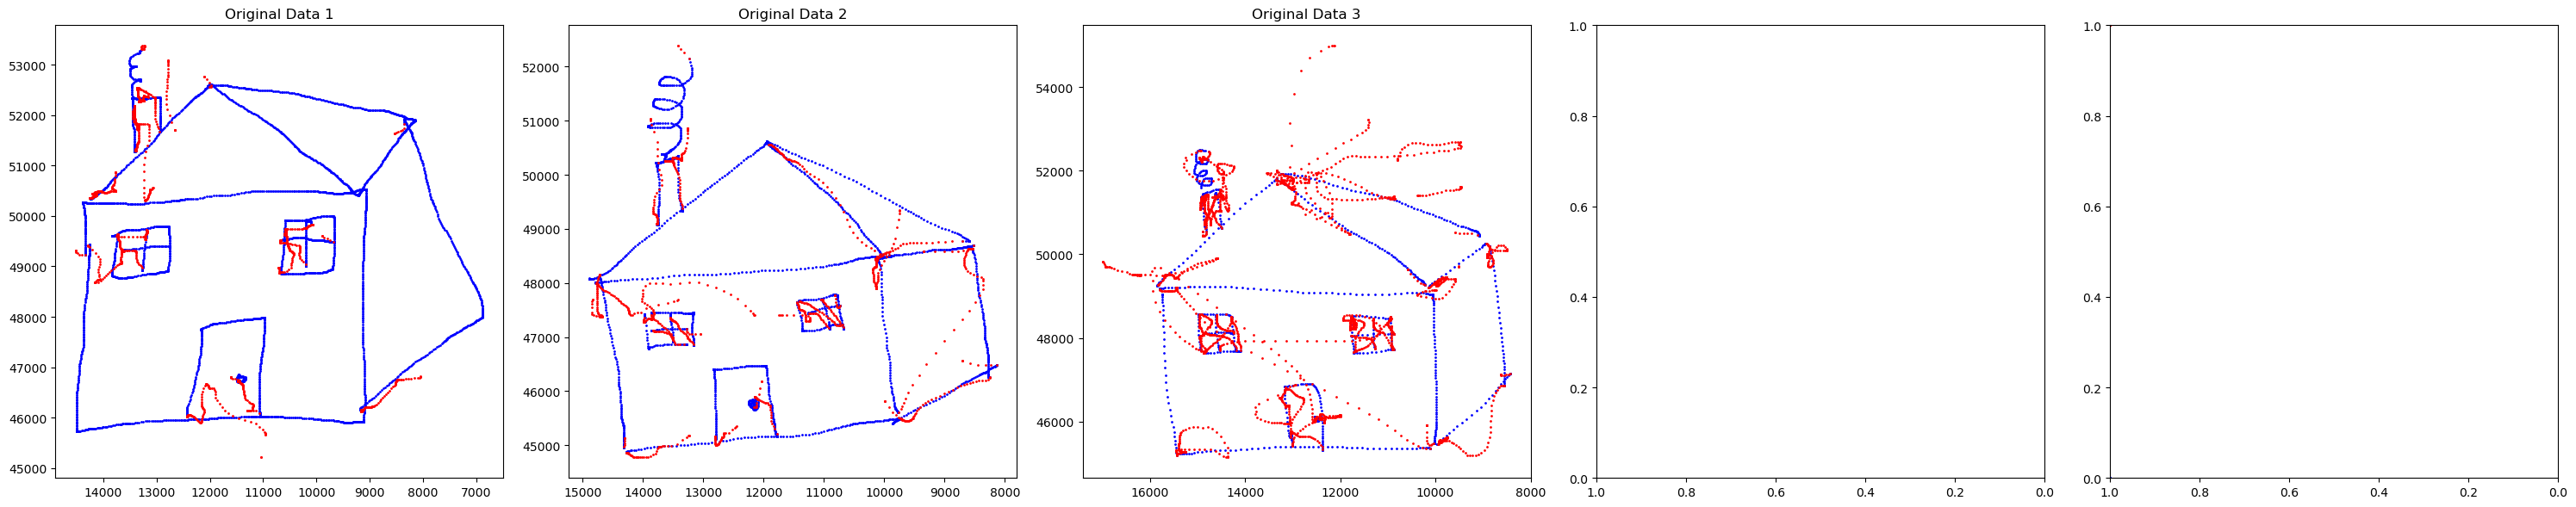

VAE model saved for epoch 10 at vae_models\epoch_10_model.h5.


Epoch 11/100: 100%|██████████| 27/27 [00:01<00:00, 18.44batch/s, Generator Loss=0.0526, Reconstruction Loss=0.0526, KL Loss=0.712]


Epoch 11: Generator Loss = 0.051137, Reconstruction Loss = 0.051136, KL Divergence Loss = 0.781772


Epoch 12/100: 100%|██████████| 27/27 [00:02<00:00, 10.42batch/s, Generator Loss=0.0373, Reconstruction Loss=0.0373, KL Loss=0.754]


Epoch 12: Generator Loss = 0.047550, Reconstruction Loss = 0.047549, KL Divergence Loss = 0.827448


Epoch 13/100: 100%|██████████| 27/27 [00:02<00:00, 13.27batch/s, Generator Loss=0.0301, Reconstruction Loss=0.0301, KL Loss=0.607]


Epoch 13: Generator Loss = 0.044237, Reconstruction Loss = 0.044236, KL Divergence Loss = 0.835182


Epoch 14/100: 100%|██████████| 27/27 [00:01<00:00, 14.27batch/s, Generator Loss=0.0387, Reconstruction Loss=0.0387, KL Loss=0.951]


Epoch 14: Generator Loss = 0.041688, Reconstruction Loss = 0.041687, KL Divergence Loss = 0.892203


Epoch 15/100: 100%|██████████| 27/27 [00:01<00:00, 15.58batch/s, Generator Loss=0.036, Reconstruction Loss=0.036, KL Loss=0.752]  


Epoch 15: Generator Loss = 0.038566, Reconstruction Loss = 0.038565, KL Divergence Loss = 0.943249


Epoch 16/100: 100%|██████████| 27/27 [00:01<00:00, 16.65batch/s, Generator Loss=0.0334, Reconstruction Loss=0.0334, KL Loss=0.747]


Epoch 16: Generator Loss = 0.034939, Reconstruction Loss = 0.034938, KL Divergence Loss = 1.036778


Epoch 17/100: 100%|██████████| 27/27 [00:01<00:00, 17.19batch/s, Generator Loss=0.0167, Reconstruction Loss=0.0167, KL Loss=0.939]


Epoch 17: Generator Loss = 0.030156, Reconstruction Loss = 0.030155, KL Divergence Loss = 1.188476


Epoch 18/100: 100%|██████████| 27/27 [00:02<00:00, 13.46batch/s, Generator Loss=0.0243, Reconstruction Loss=0.0243, KL Loss=1.27]


Epoch 18: Generator Loss = 0.027577, Reconstruction Loss = 0.027576, KL Divergence Loss = 1.293253


Epoch 19/100: 100%|██████████| 27/27 [00:01<00:00, 24.46batch/s, Generator Loss=0.0101, Reconstruction Loss=0.0101, KL Loss=1.49]


Epoch 19: Generator Loss = 0.023630, Reconstruction Loss = 0.023629, KL Divergence Loss = 1.439193


Epoch 20/100: 100%|██████████| 27/27 [00:01<00:00, 14.14batch/s, Generator Loss=0.00409, Reconstruction Loss=0.00409, KL Loss=1.45]


Epoch 20: Generator Loss = 0.020485, Reconstruction Loss = 0.020484, KL Divergence Loss = 1.639947


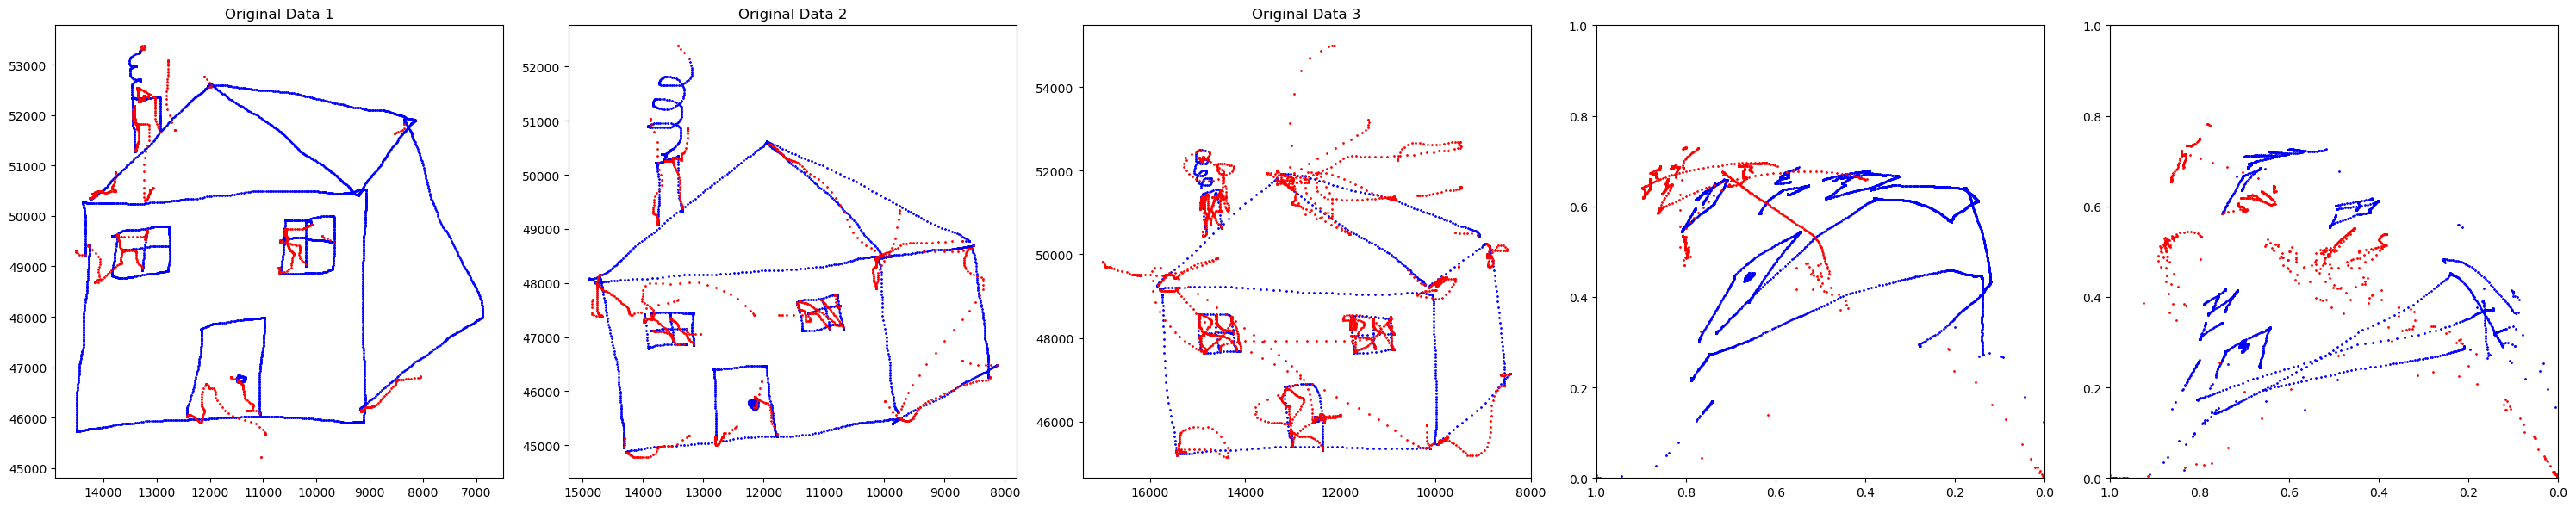

VAE model saved for epoch 20 at vae_models\epoch_20_model.h5.


Epoch 21/100: 100%|██████████| 27/27 [00:01<00:00, 17.90batch/s, Generator Loss=0.00609, Reconstruction Loss=0.00609, KL Loss=1.99]


Epoch 21: Generator Loss = 0.019829, Reconstruction Loss = 0.019828, KL Divergence Loss = 1.773675


Epoch 22/100: 100%|██████████| 27/27 [00:02<00:00, 11.77batch/s, Generator Loss=0.0105, Reconstruction Loss=0.0104, KL Loss=1.77]  


Epoch 22: Generator Loss = 0.018626, Reconstruction Loss = 0.018625, KL Divergence Loss = 1.829610


Epoch 23/100: 100%|██████████| 27/27 [00:02<00:00, 13.46batch/s, Generator Loss=0.00475, Reconstruction Loss=0.00475, KL Loss=1.43]


Epoch 23: Generator Loss = 0.017199, Reconstruction Loss = 0.017197, KL Divergence Loss = 1.884708


Epoch 24/100: 100%|██████████| 27/27 [00:01<00:00, 14.93batch/s, Generator Loss=0.00622, Reconstruction Loss=0.00622, KL Loss=1.43]


Epoch 24: Generator Loss = 0.016010, Reconstruction Loss = 0.016008, KL Divergence Loss = 1.931059


Epoch 25/100: 100%|██████████| 27/27 [00:01<00:00, 25.39batch/s, Generator Loss=0.0117, Reconstruction Loss=0.0117, KL Loss=1.63]  


Epoch 25: Generator Loss = 0.014567, Reconstruction Loss = 0.014565, KL Divergence Loss = 1.957838


Epoch 26/100: 100%|██████████| 27/27 [00:01<00:00, 18.65batch/s, Generator Loss=0.00564, Reconstruction Loss=0.00564, KL Loss=1.81]


Epoch 26: Generator Loss = 0.011252, Reconstruction Loss = 0.011250, KL Divergence Loss = 2.022932


Epoch 27/100: 100%|██████████| 27/27 [00:01<00:00, 18.09batch/s, Generator Loss=0.00832, Reconstruction Loss=0.00832, KL Loss=2.07]


Epoch 27: Generator Loss = 0.009218, Reconstruction Loss = 0.009216, KL Divergence Loss = 2.146126


Epoch 28/100: 100%|██████████| 27/27 [00:01<00:00, 15.00batch/s, Generator Loss=0.00674, Reconstruction Loss=0.00674, KL Loss=1.93]


Epoch 28: Generator Loss = 0.007266, Reconstruction Loss = 0.007264, KL Divergence Loss = 2.202369


Epoch 29/100: 100%|██████████| 27/27 [00:01<00:00, 18.83batch/s, Generator Loss=0.00258, Reconstruction Loss=0.00258, KL Loss=1.39]


Epoch 29: Generator Loss = 0.006057, Reconstruction Loss = 0.006054, KL Divergence Loss = 2.257777


Epoch 30/100: 100%|██████████| 27/27 [00:01<00:00, 14.85batch/s, Generator Loss=0.00281, Reconstruction Loss=0.0028, KL Loss=1.84] 


Epoch 30: Generator Loss = 0.004787, Reconstruction Loss = 0.004785, KL Divergence Loss = 2.412757


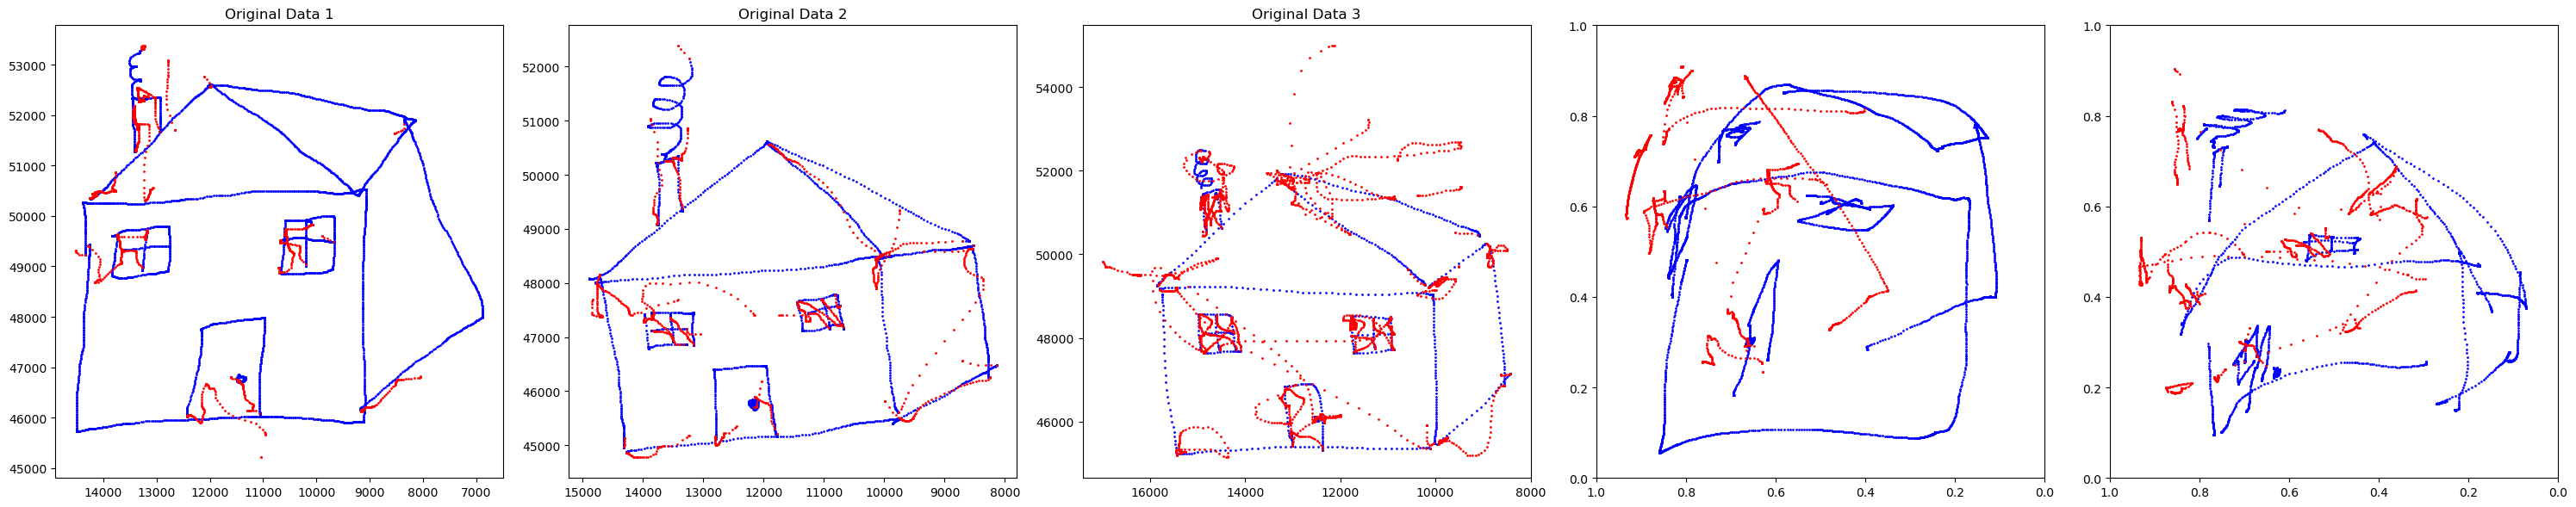

VAE model saved for epoch 30 at vae_models\epoch_30_model.h5.


Epoch 31/100: 100%|██████████| 27/27 [00:01<00:00, 19.68batch/s, Generator Loss=0.00538, Reconstruction Loss=0.00538, KL Loss=1.48]


Epoch 31: Generator Loss = 0.004001, Reconstruction Loss = 0.003998, KL Divergence Loss = 2.493434


Epoch 32/100: 100%|██████████| 27/27 [00:01<00:00, 17.80batch/s, Generator Loss=0.00436, Reconstruction Loss=0.00436, KL Loss=2.07]


Epoch 32: Generator Loss = 0.003357, Reconstruction Loss = 0.003355, KL Divergence Loss = 2.661873


Epoch 33/100: 100%|██████████| 27/27 [00:01<00:00, 16.42batch/s, Generator Loss=0.0014, Reconstruction Loss=0.00139, KL Loss=2.35] 


Epoch 33: Generator Loss = 0.002471, Reconstruction Loss = 0.002468, KL Divergence Loss = 2.839877


Epoch 34/100: 100%|██████████| 27/27 [00:01<00:00, 24.55batch/s, Generator Loss=0.00101, Reconstruction Loss=0.00101, KL Loss=2.8] 


Epoch 34: Generator Loss = 0.001939, Reconstruction Loss = 0.001936, KL Divergence Loss = 3.041154


Epoch 35/100: 100%|██████████| 27/27 [00:01<00:00, 17.83batch/s, Generator Loss=0.00309, Reconstruction Loss=0.00309, KL Loss=2.33]


Epoch 35: Generator Loss = 0.001693, Reconstruction Loss = 0.001690, KL Divergence Loss = 3.198056


Epoch 36/100: 100%|██████████| 27/27 [00:01<00:00, 21.24batch/s, Generator Loss=0.00278, Reconstruction Loss=0.00277, KL Loss=3.2]   


Epoch 36: Generator Loss = 0.001508, Reconstruction Loss = 0.001505, KL Divergence Loss = 3.403117


Epoch 37/100: 100%|██████████| 27/27 [00:01<00:00, 22.64batch/s, Generator Loss=0.000546, Reconstruction Loss=0.000542, KL Loss=3.84]


Epoch 37: Generator Loss = 0.001296, Reconstruction Loss = 0.001293, KL Divergence Loss = 3.585160


Epoch 38/100: 100%|██████████| 27/27 [00:01<00:00, 18.46batch/s, Generator Loss=0.000739, Reconstruction Loss=0.000736, KL Loss=2.85]


Epoch 38: Generator Loss = 0.001226, Reconstruction Loss = 0.001222, KL Divergence Loss = 3.638892


Epoch 39/100: 100%|██████████| 27/27 [00:01<00:00, 22.99batch/s, Generator Loss=0.000885, Reconstruction Loss=0.000882, KL Loss=2.41]


Epoch 39: Generator Loss = 0.001033, Reconstruction Loss = 0.001029, KL Divergence Loss = 3.720492


Epoch 40/100: 100%|██████████| 27/27 [00:01<00:00, 19.22batch/s, Generator Loss=0.000956, Reconstruction Loss=0.000953, KL Loss=2.38]


Epoch 40: Generator Loss = 0.000937, Reconstruction Loss = 0.000934, KL Divergence Loss = 3.855313


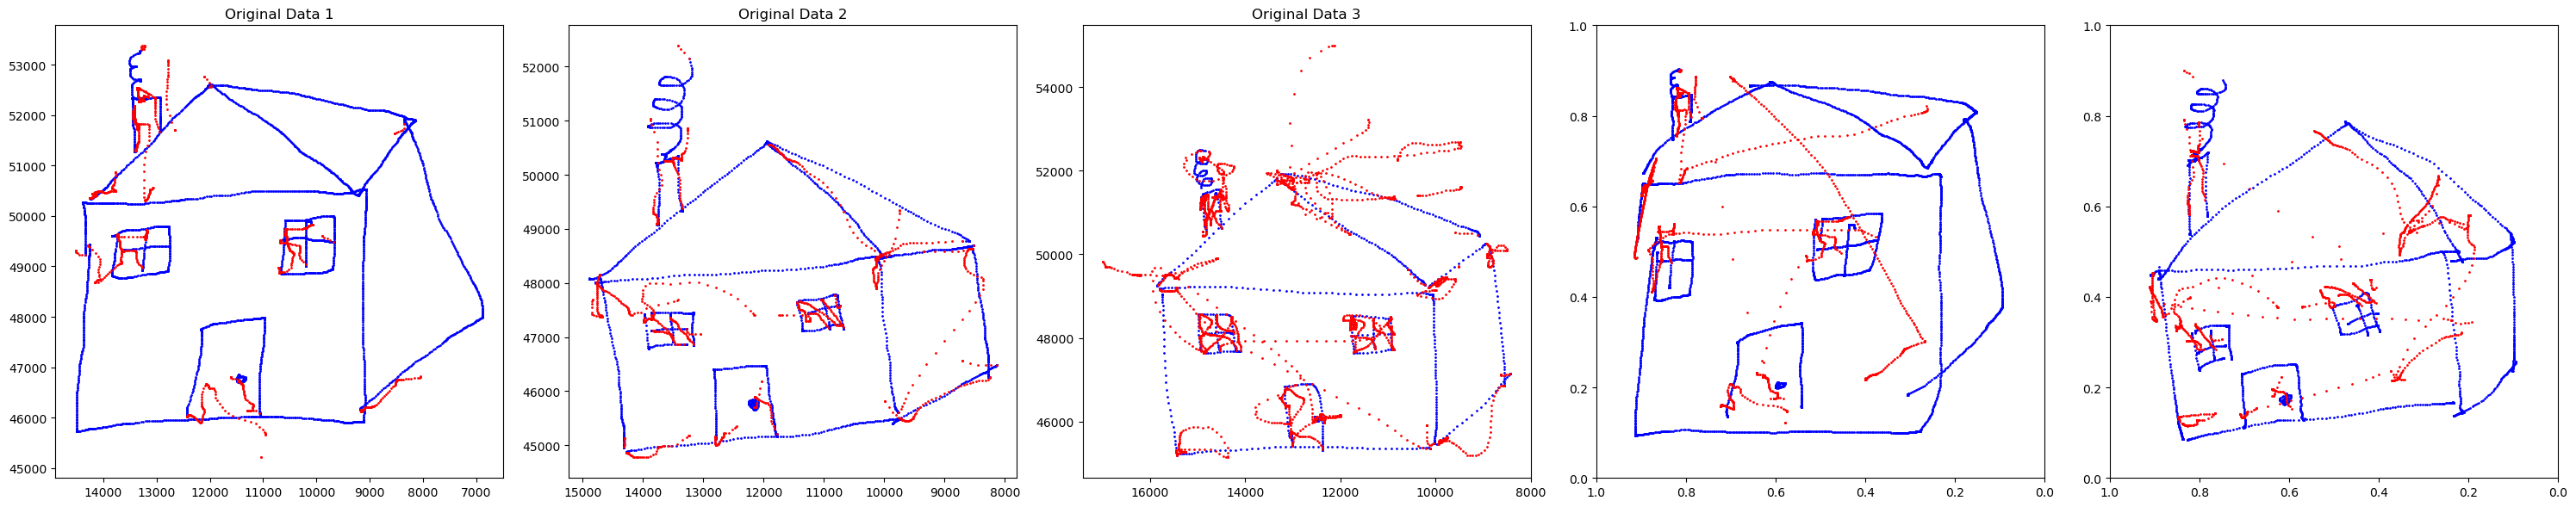

VAE model saved for epoch 40 at vae_models\epoch_40_model.h5.


Epoch 41/100: 100%|██████████| 27/27 [00:01<00:00, 24.61batch/s, Generator Loss=0.00053, Reconstruction Loss=0.000527, KL Loss=3.39] 


Epoch 41: Generator Loss = 0.000927, Reconstruction Loss = 0.000923, KL Divergence Loss = 3.973211


Epoch 42/100: 100%|██████████| 27/27 [00:01<00:00, 16.16batch/s, Generator Loss=0.00049, Reconstruction Loss=0.000487, KL Loss=3.28] 


Epoch 42: Generator Loss = 0.000864, Reconstruction Loss = 0.000860, KL Divergence Loss = 4.061740


Epoch 43/100: 100%|██████████| 27/27 [00:01<00:00, 16.36batch/s, Generator Loss=0.000913, Reconstruction Loss=0.00091, KL Loss=3.05] 


Epoch 43: Generator Loss = 0.000836, Reconstruction Loss = 0.000832, KL Divergence Loss = 4.116566


Epoch 44/100: 100%|██████████| 27/27 [00:01<00:00, 19.25batch/s, Generator Loss=0.000375, Reconstruction Loss=0.000371, KL Loss=4.32]


Epoch 44: Generator Loss = 0.000758, Reconstruction Loss = 0.000753, KL Divergence Loss = 4.234812


Epoch 45/100: 100%|██████████| 27/27 [00:01<00:00, 26.13batch/s, Generator Loss=0.000643, Reconstruction Loss=0.00064, KL Loss=3.84] 


Epoch 45: Generator Loss = 0.000740, Reconstruction Loss = 0.000736, KL Divergence Loss = 4.294656


Epoch 46/100: 100%|██████████| 27/27 [00:01<00:00, 17.89batch/s, Generator Loss=0.000731, Reconstruction Loss=0.000728, KL Loss=2.96]


Epoch 46: Generator Loss = 0.000738, Reconstruction Loss = 0.000733, KL Divergence Loss = 4.305720


Epoch 47/100: 100%|██████████| 27/27 [00:00<00:00, 28.07batch/s, Generator Loss=0.000781, Reconstruction Loss=0.000775, KL Loss=5.11]


Epoch 47: Generator Loss = 0.000709, Reconstruction Loss = 0.000705, KL Divergence Loss = 4.431013


Epoch 48/100: 100%|██████████| 27/27 [00:01<00:00, 16.20batch/s, Generator Loss=0.000242, Reconstruction Loss=0.000238, KL Loss=4.01]


Epoch 48: Generator Loss = 0.000631, Reconstruction Loss = 0.000626, KL Divergence Loss = 4.442919


Epoch 49/100: 100%|██████████| 27/27 [00:01<00:00, 24.37batch/s, Generator Loss=0.000361, Reconstruction Loss=0.000358, KL Loss=3.73]


Epoch 49: Generator Loss = 0.000548, Reconstruction Loss = 0.000543, KL Divergence Loss = 4.482059


Epoch 50/100: 100%|██████████| 27/27 [00:01<00:00, 19.91batch/s, Generator Loss=0.000293, Reconstruction Loss=0.000288, KL Loss=4.66]


Epoch 50: Generator Loss = 0.000627, Reconstruction Loss = 0.000623, KL Divergence Loss = 4.576196


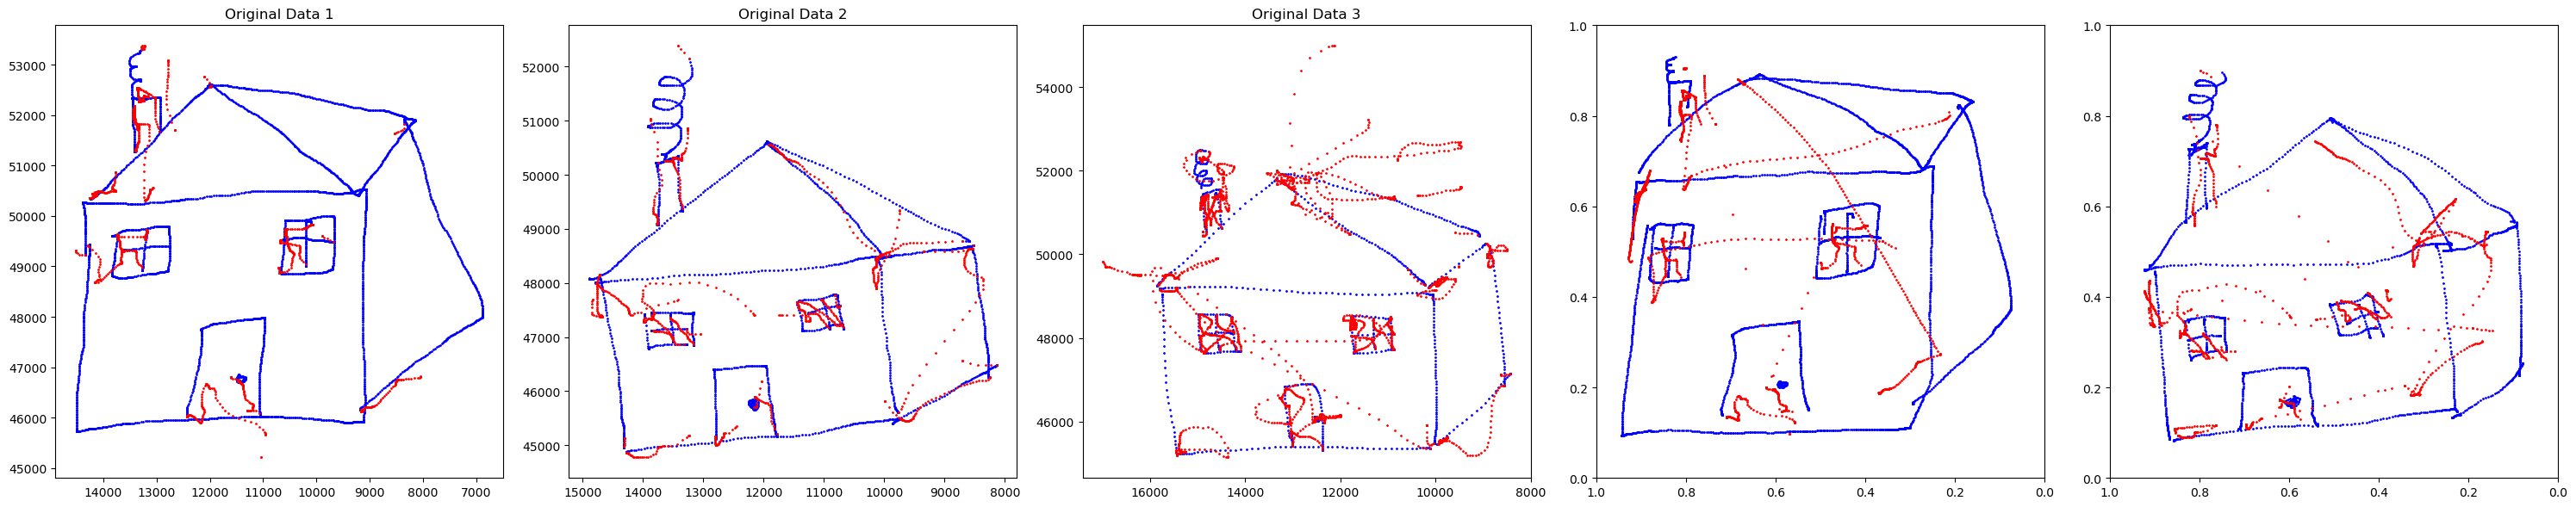

VAE model saved for epoch 50 at vae_models\epoch_50_model.h5.


Epoch 51/100: 100%|██████████| 27/27 [00:01<00:00, 23.49batch/s, Generator Loss=0.000274, Reconstruction Loss=0.00027, KL Loss=4.74] 


Epoch 51: Generator Loss = 0.000548, Reconstruction Loss = 0.000543, KL Divergence Loss = 4.615252


Epoch 52/100: 100%|██████████| 27/27 [00:01<00:00, 16.25batch/s, Generator Loss=0.000172, Reconstruction Loss=0.000169, KL Loss=3.44]


Epoch 52: Generator Loss = 0.000520, Reconstruction Loss = 0.000515, KL Divergence Loss = 4.628283


Epoch 53/100: 100%|██████████| 27/27 [00:01<00:00, 17.61batch/s, Generator Loss=0.00033, Reconstruction Loss=0.000327, KL Loss=2.98] 


Epoch 53: Generator Loss = 0.000481, Reconstruction Loss = 0.000477, KL Divergence Loss = 4.645485


Epoch 54/100: 100%|██████████| 27/27 [00:01<00:00, 14.66batch/s, Generator Loss=0.000661, Reconstruction Loss=0.000657, KL Loss=3.95]


Epoch 54: Generator Loss = 0.000497, Reconstruction Loss = 0.000492, KL Divergence Loss = 4.748538


Epoch 55/100: 100%|██████████| 27/27 [00:01<00:00, 18.39batch/s, Generator Loss=0.000295, Reconstruction Loss=0.00029, KL Loss=4.71] 


Epoch 55: Generator Loss = 0.000458, Reconstruction Loss = 0.000453, KL Divergence Loss = 4.829874


Epoch 56/100: 100%|██████████| 27/27 [00:00<00:00, 28.99batch/s, Generator Loss=0.000275, Reconstruction Loss=0.000271, KL Loss=4.22]


Epoch 56: Generator Loss = 0.000462, Reconstruction Loss = 0.000457, KL Divergence Loss = 4.848590


Epoch 57/100: 100%|██████████| 27/27 [00:01<00:00, 19.31batch/s, Generator Loss=0.000254, Reconstruction Loss=0.00025, KL Loss=4.15] 


Epoch 57: Generator Loss = 0.000419, Reconstruction Loss = 0.000414, KL Divergence Loss = 4.888787


Epoch 58/100: 100%|██████████| 27/27 [00:01<00:00, 18.98batch/s, Generator Loss=0.000685, Reconstruction Loss=0.00068, KL Loss=4.4]  


Epoch 58: Generator Loss = 0.000426, Reconstruction Loss = 0.000421, KL Divergence Loss = 4.952673


Epoch 59/100: 100%|██████████| 27/27 [00:01<00:00, 16.60batch/s, Generator Loss=0.000424, Reconstruction Loss=0.00042, KL Loss=4.73] 


Epoch 59: Generator Loss = 0.000413, Reconstruction Loss = 0.000408, KL Divergence Loss = 5.010474


Epoch 60/100: 100%|██████████| 27/27 [00:01<00:00, 24.40batch/s, Generator Loss=0.000262, Reconstruction Loss=0.000257, KL Loss=4.68]


Epoch 60: Generator Loss = 0.000428, Reconstruction Loss = 0.000423, KL Divergence Loss = 5.063242


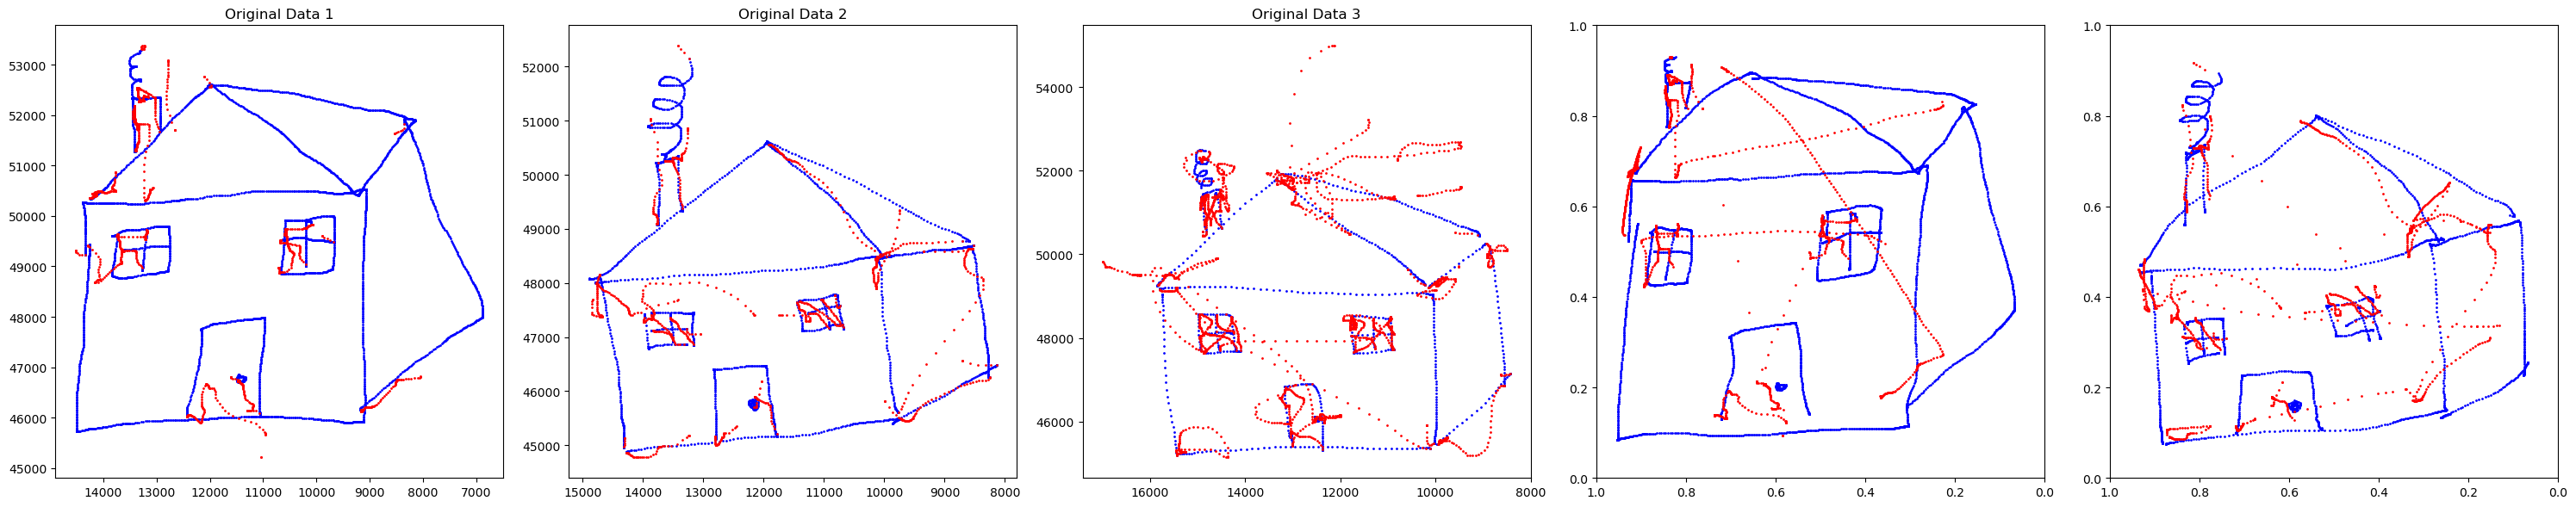

VAE model saved for epoch 60 at vae_models\epoch_60_model.h5.


Epoch 61/100: 100%|██████████| 27/27 [00:01<00:00, 22.04batch/s, Generator Loss=0.000227, Reconstruction Loss=0.000221, KL Loss=5.17]


Epoch 61: Generator Loss = 0.000375, Reconstruction Loss = 0.000370, KL Divergence Loss = 5.113953


Epoch 62/100: 100%|██████████| 27/27 [00:01<00:00, 16.05batch/s, Generator Loss=0.000331, Reconstruction Loss=0.000328, KL Loss=3.33]


Epoch 62: Generator Loss = 0.000365, Reconstruction Loss = 0.000360, KL Divergence Loss = 5.089816


Epoch 63/100: 100%|██████████| 27/27 [00:01<00:00, 16.77batch/s, Generator Loss=9.76e-5, Reconstruction Loss=9.31e-5, KL Loss=4.49]  


Epoch 63: Generator Loss = 0.000362, Reconstruction Loss = 0.000357, KL Divergence Loss = 5.178063


Epoch 64/100: 100%|██████████| 27/27 [00:01<00:00, 25.55batch/s, Generator Loss=0.000336, Reconstruction Loss=0.000331, KL Loss=4.93]


Epoch 64: Generator Loss = 0.000373, Reconstruction Loss = 0.000368, KL Divergence Loss = 5.222046


Epoch 65/100: 100%|██████████| 27/27 [00:01<00:00, 25.57batch/s, Generator Loss=0.000134, Reconstruction Loss=0.000128, KL Loss=5.59]


Epoch 65: Generator Loss = 0.000358, Reconstruction Loss = 0.000353, KL Divergence Loss = 5.279932


Epoch 66/100: 100%|██████████| 27/27 [00:01<00:00, 19.69batch/s, Generator Loss=7.38e-5, Reconstruction Loss=6.9e-5, KL Loss=4.76]   


Epoch 66: Generator Loss = 0.000335, Reconstruction Loss = 0.000329, KL Divergence Loss = 5.271267


Epoch 67/100: 100%|██████████| 27/27 [00:01<00:00, 21.12batch/s, Generator Loss=0.00144, Reconstruction Loss=0.00144, KL Loss=3.52]  


Epoch 67: Generator Loss = 0.000370, Reconstruction Loss = 0.000365, KL Divergence Loss = 5.258222


Epoch 68/100: 100%|██████████| 27/27 [00:01<00:00, 24.52batch/s, Generator Loss=0.000185, Reconstruction Loss=0.00018, KL Loss=5]    


Epoch 68: Generator Loss = 0.000346, Reconstruction Loss = 0.000341, KL Divergence Loss = 5.381265


Epoch 69/100: 100%|██████████| 27/27 [00:01<00:00, 17.98batch/s, Generator Loss=0.000423, Reconstruction Loss=0.000419, KL Loss=4.32]


Epoch 69: Generator Loss = 0.000330, Reconstruction Loss = 0.000325, KL Divergence Loss = 5.393055


Epoch 70/100: 100%|██████████| 27/27 [00:01<00:00, 22.27batch/s, Generator Loss=0.000341, Reconstruction Loss=0.000337, KL Loss=3.84]


Epoch 70: Generator Loss = 0.000302, Reconstruction Loss = 0.000296, KL Divergence Loss = 5.398118


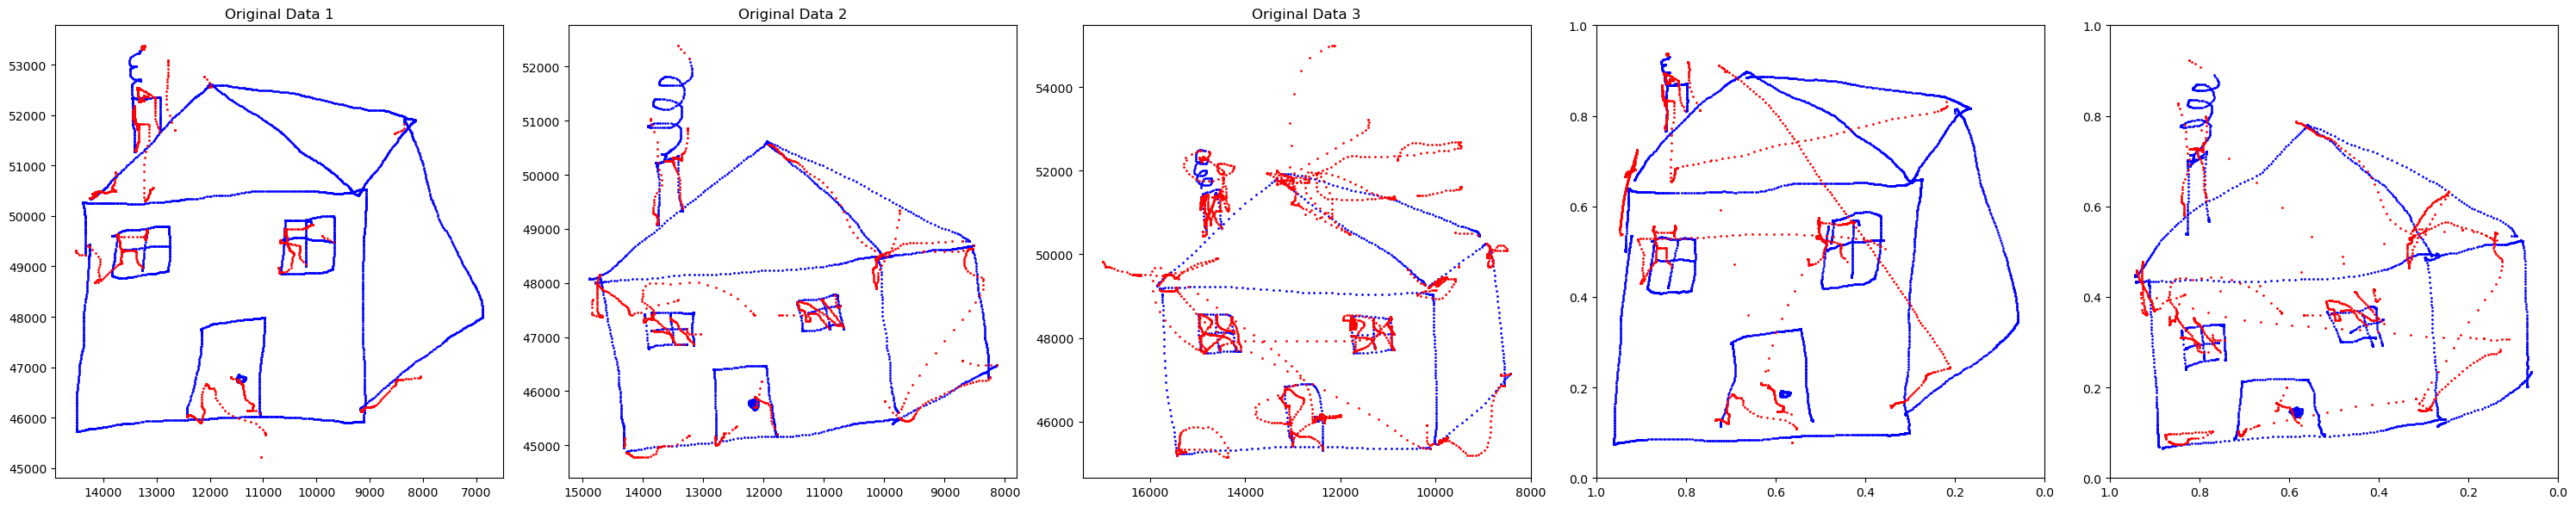

VAE model saved for epoch 70 at vae_models\epoch_70_model.h5.


Epoch 71/100: 100%|██████████| 27/27 [00:01<00:00, 26.57batch/s, Generator Loss=0.000172, Reconstruction Loss=0.000166, KL Loss=5.45]


Epoch 71: Generator Loss = 0.000282, Reconstruction Loss = 0.000276, KL Divergence Loss = 5.480275


Epoch 72/100: 100%|██████████| 27/27 [00:01<00:00, 16.24batch/s, Generator Loss=0.000193, Reconstruction Loss=0.000189, KL Loss=4.08]


Epoch 72: Generator Loss = 0.000288, Reconstruction Loss = 0.000282, KL Divergence Loss = 5.478239


Epoch 73/100: 100%|██████████| 27/27 [00:01<00:00, 15.06batch/s, Generator Loss=0.000422, Reconstruction Loss=0.000417, KL Loss=5.24]


Epoch 73: Generator Loss = 0.000297, Reconstruction Loss = 0.000291, KL Divergence Loss = 5.543363


Epoch 74/100: 100%|██████████| 27/27 [00:01<00:00, 24.01batch/s, Generator Loss=0.000146, Reconstruction Loss=0.000142, KL Loss=3.94]


Epoch 74: Generator Loss = 0.000274, Reconstruction Loss = 0.000268, KL Divergence Loss = 5.526426


Epoch 75/100: 100%|██████████| 27/27 [00:01<00:00, 20.44batch/s, Generator Loss=0.000115, Reconstruction Loss=0.000109, KL Loss=5.83]


Epoch 75: Generator Loss = 0.000271, Reconstruction Loss = 0.000266, KL Divergence Loss = 5.619702


Epoch 76/100: 100%|██████████| 27/27 [00:00<00:00, 27.70batch/s, Generator Loss=0.000116, Reconstruction Loss=0.000111, KL Loss=5.28]


Epoch 76: Generator Loss = 0.000266, Reconstruction Loss = 0.000260, KL Divergence Loss = 5.632820


Epoch 77/100: 100%|██████████| 27/27 [00:01<00:00, 18.45batch/s, Generator Loss=0.0002, Reconstruction Loss=0.000196, KL Loss=4.41]  


Epoch 77: Generator Loss = 0.000263, Reconstruction Loss = 0.000257, KL Divergence Loss = 5.627508


Epoch 78/100: 100%|██████████| 27/27 [00:01<00:00, 23.56batch/s, Generator Loss=0.000167, Reconstruction Loss=0.000162, KL Loss=4.81]


Epoch 78: Generator Loss = 0.000245, Reconstruction Loss = 0.000239, KL Divergence Loss = 5.668467


Epoch 79/100: 100%|██████████| 27/27 [00:01<00:00, 18.62batch/s, Generator Loss=0.000243, Reconstruction Loss=0.000238, KL Loss=5.74]


Epoch 79: Generator Loss = 0.000242, Reconstruction Loss = 0.000236, KL Divergence Loss = 5.748307


Epoch 80/100: 100%|██████████| 27/27 [00:01<00:00, 21.30batch/s, Generator Loss=0.000256, Reconstruction Loss=0.000251, KL Loss=5.08]


Epoch 80: Generator Loss = 0.000232, Reconstruction Loss = 0.000226, KL Divergence Loss = 5.763621


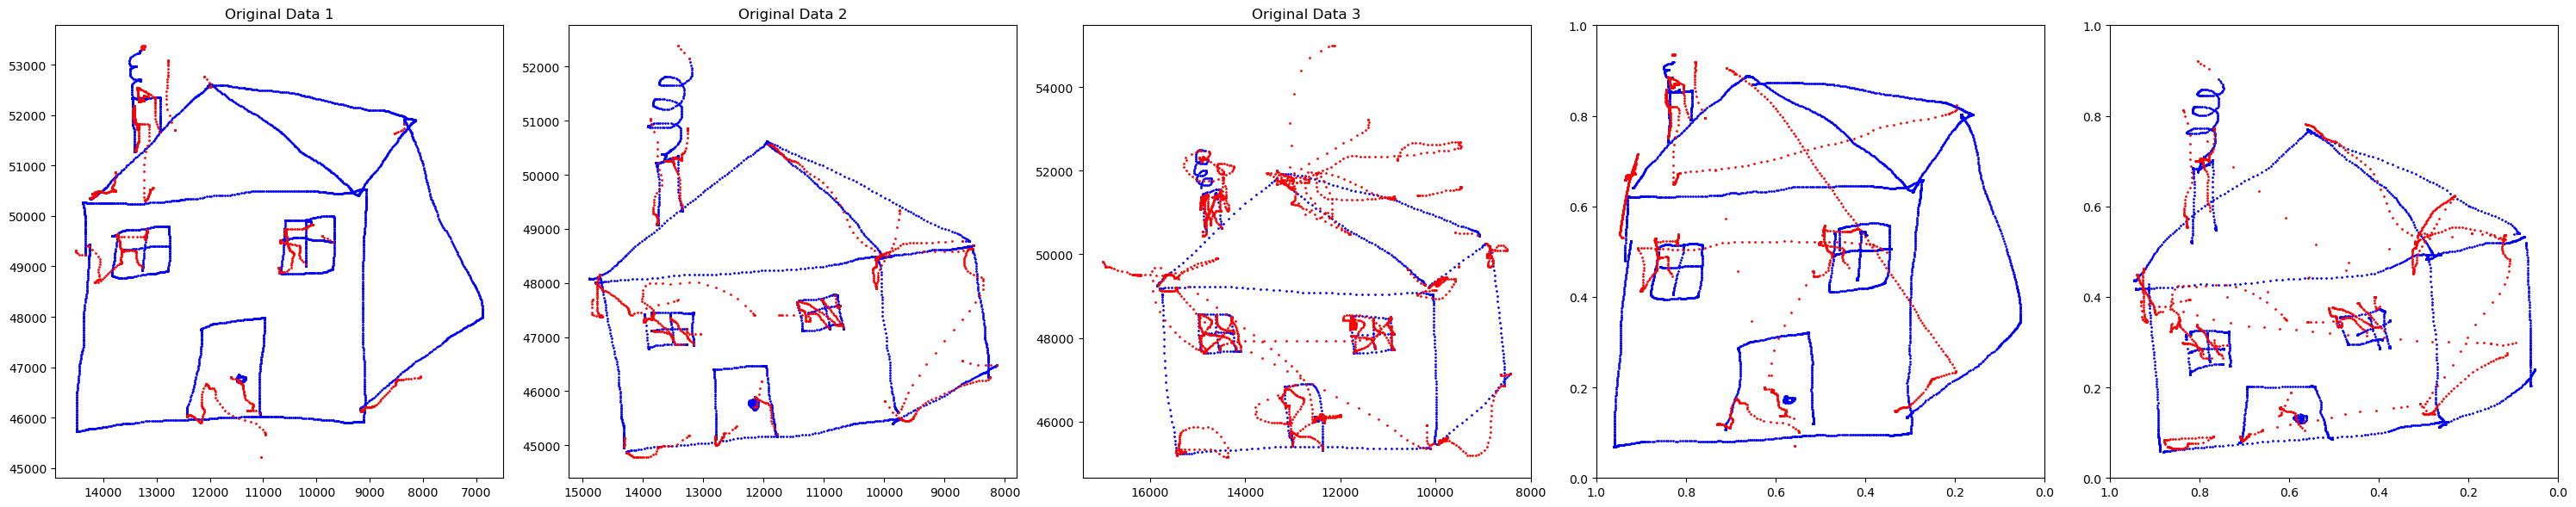

VAE model saved for epoch 80 at vae_models\epoch_80_model.h5.


Epoch 81/100: 100%|██████████| 27/27 [00:01<00:00, 15.94batch/s, Generator Loss=0.000279, Reconstruction Loss=0.000274, KL Loss=4.63]


Epoch 81: Generator Loss = 0.000262, Reconstruction Loss = 0.000256, KL Divergence Loss = 5.781600


Epoch 82/100: 100%|██████████| 27/27 [00:01<00:00, 20.91batch/s, Generator Loss=0.000237, Reconstruction Loss=0.000232, KL Loss=4.18]


Epoch 82: Generator Loss = 0.000269, Reconstruction Loss = 0.000263, KL Divergence Loss = 5.780230


Epoch 83/100: 100%|██████████| 27/27 [00:01<00:00, 14.96batch/s, Generator Loss=0.000357, Reconstruction Loss=0.000353, KL Loss=3.96]


Epoch 83: Generator Loss = 0.000267, Reconstruction Loss = 0.000262, KL Divergence Loss = 5.774022


Epoch 84/100: 100%|██████████| 27/27 [00:01<00:00, 17.15batch/s, Generator Loss=0.00017, Reconstruction Loss=0.000166, KL Loss=4.68] 


Epoch 84: Generator Loss = 0.000262, Reconstruction Loss = 0.000256, KL Divergence Loss = 5.816699


Epoch 85/100: 100%|██████████| 27/27 [00:01<00:00, 18.53batch/s, Generator Loss=0.000223, Reconstruction Loss=0.000218, KL Loss=5.33]


Epoch 85: Generator Loss = 0.000227, Reconstruction Loss = 0.000221, KL Divergence Loss = 5.845644


Epoch 86/100: 100%|██████████| 27/27 [00:00<00:00, 27.76batch/s, Generator Loss=0.000119, Reconstruction Loss=0.000114, KL Loss=5.24]


Epoch 86: Generator Loss = 0.000237, Reconstruction Loss = 0.000231, KL Divergence Loss = 5.879602


Epoch 87/100: 100%|██████████| 27/27 [00:01<00:00, 18.06batch/s, Generator Loss=0.000483, Reconstruction Loss=0.000478, KL Loss=5.27]


Epoch 87: Generator Loss = 0.000237, Reconstruction Loss = 0.000231, KL Divergence Loss = 5.900385


Epoch 88/100: 100%|██████████| 27/27 [00:01<00:00, 19.21batch/s, Generator Loss=0.000209, Reconstruction Loss=0.000202, KL Loss=6.35]


Epoch 88: Generator Loss = 0.000256, Reconstruction Loss = 0.000250, KL Divergence Loss = 5.969123


Epoch 89/100: 100%|██████████| 27/27 [00:01<00:00, 22.44batch/s, Generator Loss=0.000291, Reconstruction Loss=0.000286, KL Loss=5.74]


Epoch 89: Generator Loss = 0.000259, Reconstruction Loss = 0.000253, KL Divergence Loss = 5.932827


Epoch 90/100: 100%|██████████| 27/27 [00:01<00:00, 21.99batch/s, Generator Loss=0.000258, Reconstruction Loss=0.000253, KL Loss=5.15]


Epoch 90: Generator Loss = 0.000276, Reconstruction Loss = 0.000270, KL Divergence Loss = 5.900620


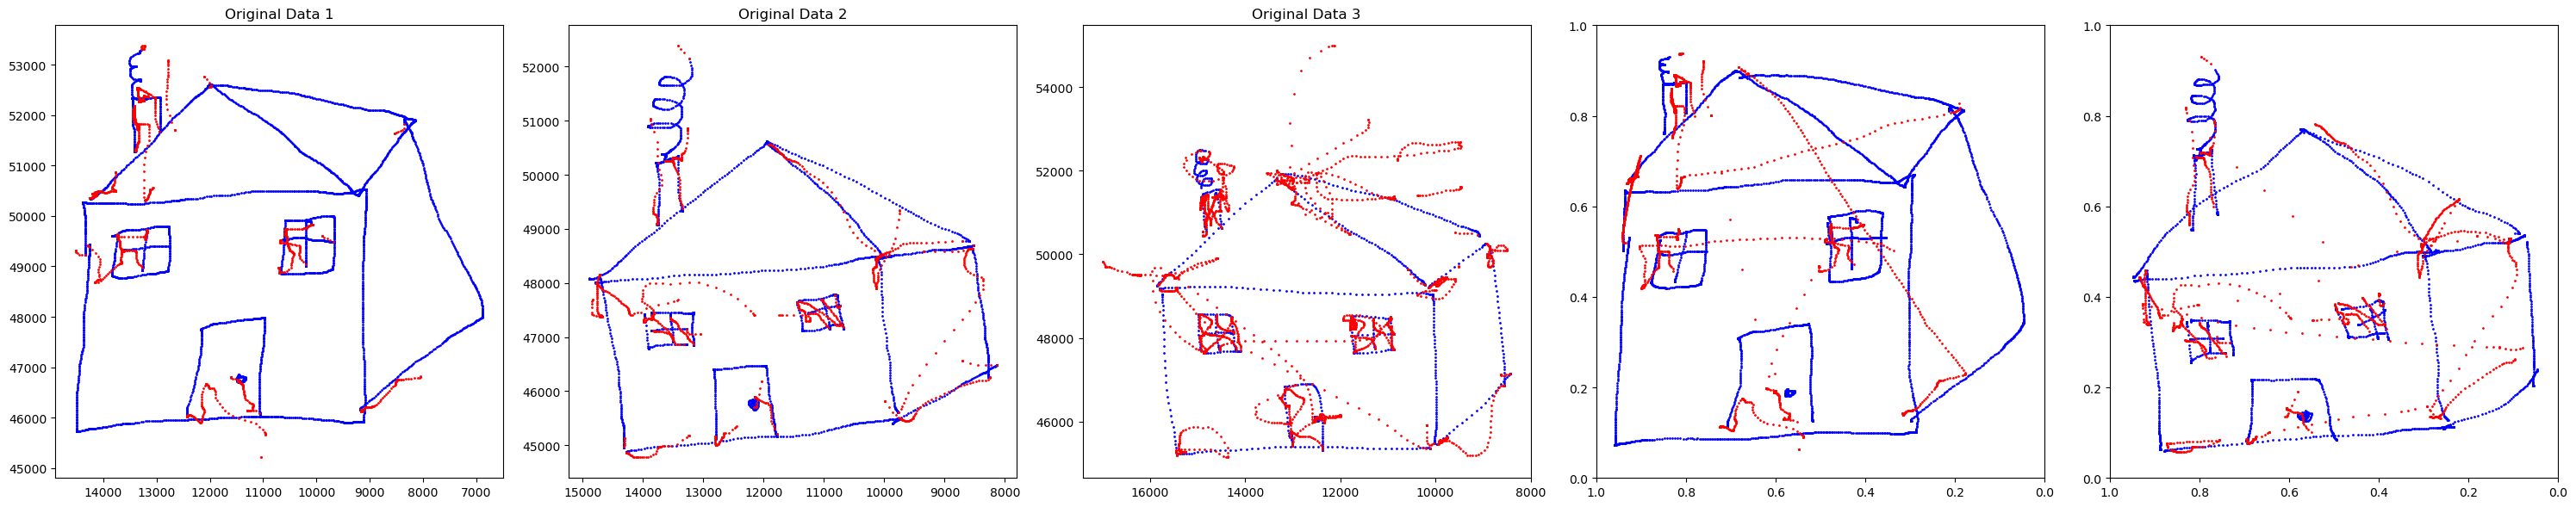

VAE model saved for epoch 90 at vae_models\epoch_90_model.h5.


Epoch 91/100: 100%|██████████| 27/27 [00:00<00:00, 27.28batch/s, Generator Loss=0.000143, Reconstruction Loss=0.000139, KL Loss=4.36]


Epoch 91: Generator Loss = 0.000251, Reconstruction Loss = 0.000245, KL Divergence Loss = 5.869693


Epoch 92/100: 100%|██████████| 27/27 [00:01<00:00, 19.23batch/s, Generator Loss=0.000178, Reconstruction Loss=0.000173, KL Loss=4.95]


Epoch 92: Generator Loss = 0.000271, Reconstruction Loss = 0.000265, KL Divergence Loss = 5.914774


Epoch 93/100: 100%|██████████| 27/27 [00:01<00:00, 20.94batch/s, Generator Loss=0.000209, Reconstruction Loss=0.000203, KL Loss=5.78]


Epoch 93: Generator Loss = 0.000233, Reconstruction Loss = 0.000227, KL Divergence Loss = 5.946664


Epoch 94/100: 100%|██████████| 27/27 [00:01<00:00, 14.84batch/s, Generator Loss=0.000259, Reconstruction Loss=0.000254, KL Loss=5.57]


Epoch 94: Generator Loss = 0.000235, Reconstruction Loss = 0.000229, KL Divergence Loss = 5.952670


Epoch 95/100: 100%|██████████| 27/27 [00:01<00:00, 20.22batch/s, Generator Loss=0.000233, Reconstruction Loss=0.000228, KL Loss=5]   


Epoch 95: Generator Loss = 0.000233, Reconstruction Loss = 0.000227, KL Divergence Loss = 5.945893


Epoch 96/100: 100%|██████████| 27/27 [00:01<00:00, 26.72batch/s, Generator Loss=0.000326, Reconstruction Loss=0.000323, KL Loss=3.85]


Epoch 96: Generator Loss = 0.000233, Reconstruction Loss = 0.000227, KL Divergence Loss = 5.946482


Epoch 97/100: 100%|██████████| 27/27 [00:01<00:00, 19.53batch/s, Generator Loss=0.0003, Reconstruction Loss=0.000296, KL Loss=4.18]  


Epoch 97: Generator Loss = 0.000229, Reconstruction Loss = 0.000223, KL Divergence Loss = 5.959820


Epoch 98/100: 100%|██████████| 27/27 [00:01<00:00, 18.35batch/s, Generator Loss=0.000624, Reconstruction Loss=0.000619, KL Loss=5.65]


Epoch 98: Generator Loss = 0.000301, Reconstruction Loss = 0.000295, KL Divergence Loss = 6.023770


Epoch 99/100: 100%|██████████| 27/27 [00:01<00:00, 20.41batch/s, Generator Loss=0.000374, Reconstruction Loss=0.000368, KL Loss=5.75]


Epoch 99: Generator Loss = 0.000338, Reconstruction Loss = 0.000332, KL Divergence Loss = 5.968848


Epoch 100/100: 100%|██████████| 27/27 [00:01<00:00, 18.14batch/s, Generator Loss=0.000146, Reconstruction Loss=0.000141, KL Loss=5.11]


Epoch 100: Generator Loss = 0.000281, Reconstruction Loss = 0.000275, KL Divergence Loss = 5.908548


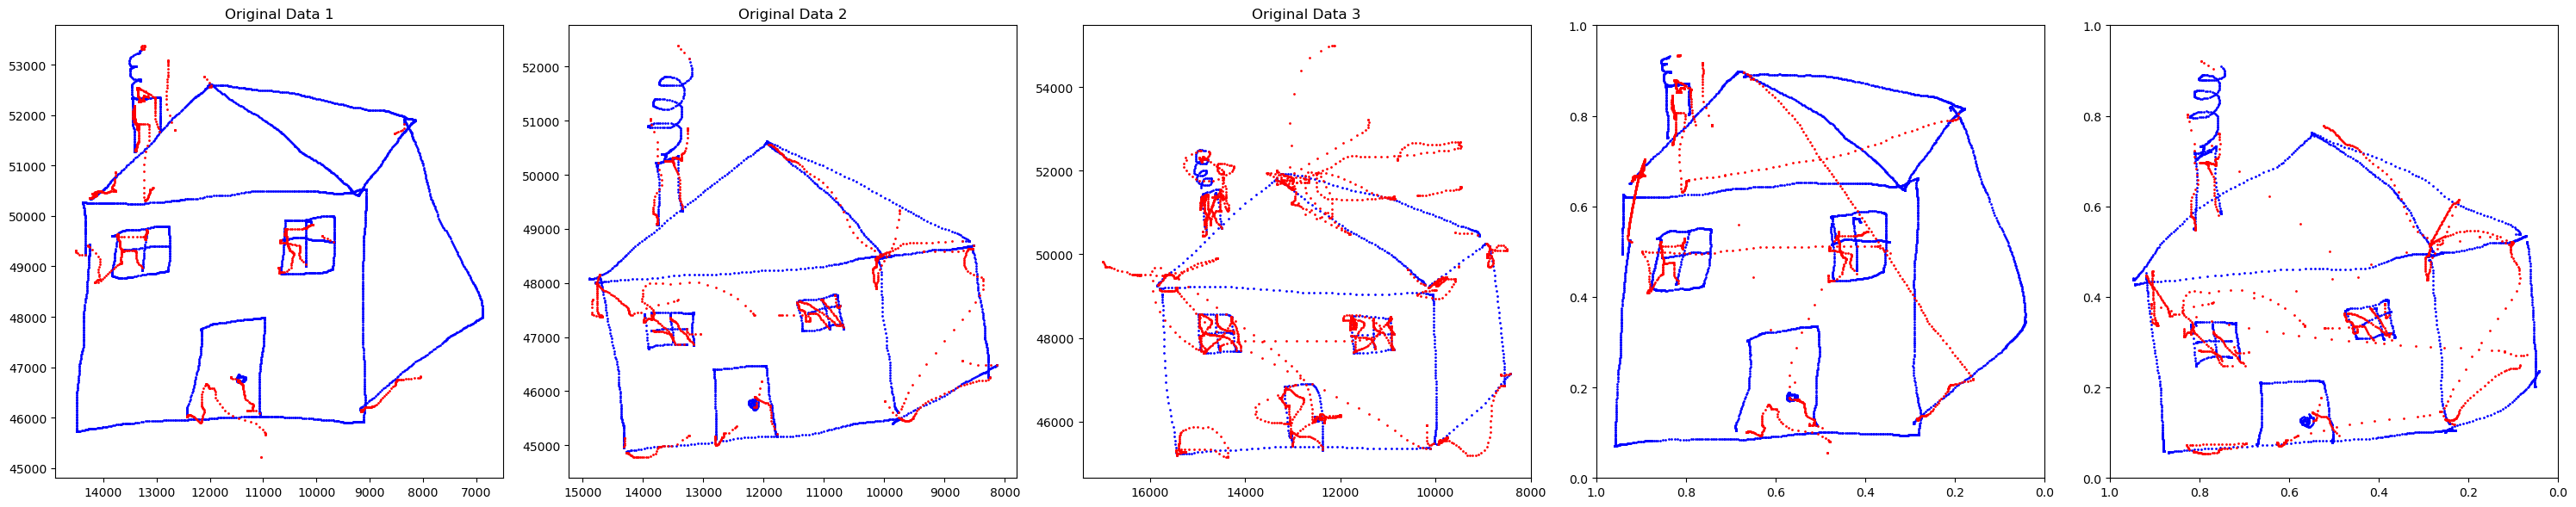

VAE model saved for epoch 100 at vae_models\epoch_100_model.h5.
Final VAE model saved.


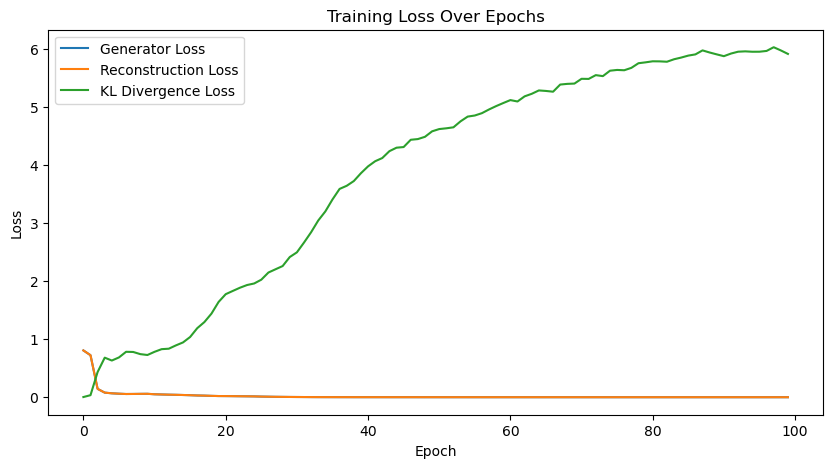

<Figure size 640x480 with 0 Axes>

In [66]:
#Cell 8
@tf.function
def train_vae_step(model, x, optimizer, lstm_discriminator=None):
    with tf.GradientTape() as tape:
        x_reconstructed, mean, logvar = model(x)
        reconstruction_loss, kl_loss, total_kl_loss = compute_loss(model, x)
        
        if lstm_discriminator is not None:
            real_predictions = lstm_discriminator(tf.expand_dims(x, axis=0))
            fake_predictions = lstm_discriminator(tf.expand_dims(x_reconstructed, axis=0))
            discriminator_loss = tf.reduce_mean(tf.keras.losses.binary_crossentropy(tf.ones_like(real_predictions), real_predictions) +
                                                tf.keras.losses.binary_crossentropy(tf.zeros_like(fake_predictions), fake_predictions))
            generator_loss = reconstruction_loss + model.beta * total_kl_loss + 0.1 * discriminator_loss
        else:
            generator_loss = reconstruction_loss + model.beta * total_kl_loss
    
    gradients = tape.gradient(generator_loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    return generator_loss, reconstruction_loss, kl_loss

@tf.function
def train_lstm_step(lstm_model, real_data, generated_data, optimizer):
    with tf.GradientTape() as tape:
        real_predictions = lstm_model(real_data)
        generated_predictions = lstm_model(generated_data)
        real_loss = tf.keras.losses.binary_crossentropy(tf.ones_like(real_predictions), real_predictions)
        generated_loss = tf.keras.losses.binary_crossentropy(tf.zeros_like(generated_predictions), generated_predictions)
        total_loss = real_loss + generated_loss
    gradients = tape.gradient(total_loss, lstm_model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, lstm_model.trainable_variables))
    return total_loss

# Initialize LSTM discriminator and optimizer
lstm_discriminator = LSTMDiscriminator()
lstm_optimizer = tf.keras.optimizers.Adam(learning_rate)

batch_size = 512
train_datasets = [tf.data.Dataset.from_tensor_slices(data).shuffle(10000).batch(batch_size) for data in processed_data]

# Set up alternating epochs
vae_epochs = 200
lstm_interval = 50
epochs = 100
visual_per_num_epoch = 10
num_augmented_files = 2

generator_loss_history = []
reconstruction_loss_history = []
kl_loss_history = []
nrmse_history = []

save_dir = "vae_models"
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

for epoch in range(epochs):
    generator_loss = 0 
    reconstruction_loss_sum = 0
    kl_loss_sum = 0
    num_batches = sum(len(dataset) for dataset in train_datasets)

    with tqdm(total=num_batches, desc=f'Epoch {epoch+1}/{epochs}', unit='batch') as pbar:
        for dataset in train_datasets:
            for batch in dataset:
                use_lstm = epoch >= vae_epochs and (epoch - vae_epochs) % lstm_interval == 0
                generator_loss_batch, reconstruction_loss, kl_loss = train_vae_step(vae, batch, optimizer, lstm_discriminator if use_lstm else None)
                generator_loss += generator_loss_batch
                reconstruction_loss_sum += reconstruction_loss
                kl_loss_sum += kl_loss
                pbar.update(1)
                pbar.set_postfix({'Generator Loss': float(generator_loss_batch), 'Reconstruction Loss': float(reconstruction_loss), 'KL Loss': float(kl_loss)})

    # Train LSTM every `lstm_interval` epochs after `vae_epochs`
    if epoch >= vae_epochs and (epoch - vae_epochs) % lstm_interval == 0:
        for data in processed_data:
            augmented_data = vae.decode(tf.random.normal(shape=(data.shape[0], latent_dim))).numpy()
            real_data = tf.expand_dims(data, axis=0)
            generated_data = tf.expand_dims(augmented_data, axis=0)
            lstm_loss = train_lstm_step(lstm_discriminator, real_data, generated_data, lstm_optimizer)
        print(f'LSTM training at epoch {epoch+1}: Discriminator Loss = {lstm_loss.numpy()}')


    avg_generator_loss = generator_loss / num_batches  # Update the average calculation
    avg_reconstruction_loss = reconstruction_loss_sum / num_batches
    avg_kl_loss = kl_loss_sum / num_batches

    generator_loss_history.append(avg_generator_loss)  # Update history list
    reconstruction_loss_history.append(avg_reconstruction_loss)
    kl_loss_history.append(avg_kl_loss)



    print(f"Epoch {epoch+1}: Generator Loss = {avg_generator_loss:.6f}, Reconstruction Loss = {avg_reconstruction_loss:.6f}, KL Divergence Loss = {avg_kl_loss:.6f}")



    # Cell 5 (visualization part)
    if (epoch + 1) % visual_per_num_epoch == 0:
        base_latent_variability = 100.0
        latent_variability_range = (0.1, 5.0)

        augmented_datasets = generate_augmented_data(vae, num_augmented_files, avg_data_points, processed_data, 
                                                     base_latent_variability, latent_variability_range)

        # Calculate actual latent variabilities and lengths used
        latent_variabilities = [base_latent_variability * np.random.uniform(latent_variability_range[0], latent_variability_range[1]) for _ in range(num_augmented_files)]
        augmented_lengths = [len(data) for data in augmented_datasets]

        fig, axs = plt.subplots(1, num_augmented_files + len(original_data_frames), figsize=(6*(num_augmented_files + len(original_data_frames)), 6))

        for i, original_data in enumerate(original_data_frames):
            original_on_paper = original_data[original_data['pen_status'] == 1]
            original_in_air = original_data[original_data['pen_status'] == 0]

            axs[i].scatter(original_on_paper['y'], original_on_paper['x'], c='b', s=1, label='On Paper')
            axs[i].scatter(original_in_air['y'], original_in_air['x'], c='r', s=1, label='In Air')
            axs[i].set_title(f'Original Data {i+1}')
            axs[i].invert_xaxis()

        # Set consistent axis limits for square aspect ratio for both original and augmented data
        x_min = min(data[:, 0].min() for data in processed_data)
        x_max = max(data[:, 0].max() for data in processed_data)
        y_min = min(data[:, 1].min() for data in processed_data)
        y_max = max(data[:, 1].max() for data in processed_data)

        for i, (augmented_data, latent_var, length) in enumerate(zip(augmented_datasets, latent_variabilities, augmented_lengths)):
            augmented_on_paper = augmented_data[augmented_data[:, 3] == 1]
            augmented_in_air = augmented_data[augmented_data[:, 3] == 0]

            axs[i+len(original_data_frames)].scatter(augmented_on_paper[:, 1], augmented_on_paper[:, 0], c='b', s=1, label='On Paper')
            axs[i+len(original_data_frames)].scatter(augmented_in_air[:, 1], augmented_in_air[:, 0], c='r', s=1, label='In Air')
            axs[i+len(original_data_frames)].invert_xaxis()
            axs[i+len(original_data_frames)].set_xlim(y_max, y_min)
            axs[i+len(original_data_frames)].set_ylim(x_min, x_max)

        plt.tight_layout()
        plt.show()
        # Save VAE model after each epoch, directly into the `vae_models` folder
        model_save_path = os.path.join(save_dir, f"epoch_{epoch+1}_model.h5")
        vae.save(model_save_path)
        print(f"VAE model saved for epoch {epoch+1} at {model_save_path}.")

# Final output and plots
plt.ioff()
plt.show()

vae.save('pentab_saved_model.h5')
print("Final VAE model saved.")

# Plot generator loss history
plt.figure(figsize=(10, 5))
plt.plot(generator_loss_history, label='Generator Loss')  # Update label
plt.plot(reconstruction_loss_history, label='Reconstruction Loss')
plt.plot(kl_loss_history, label='KL Divergence Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.legend()
plt.show()

plt.tight_layout()
plt.show()

Pretrained VAE model loaded.
Starting augmentation iteration 1
Augmented data saved to augmented_data\synthetic_u00001s00001_hw00002(3).svc
Augmented data saved to augmented_data_nested\u00001s00001_hw00002.svc
Shape of augmented data for u00001s00001_hw00002.svc: (5971, 7)
Augmented data saved to augmented_data\synthetic_u00002s00001_hw00002.svc
Augmented data saved to augmented_data_nested\u00002s00001_hw00002.svc
Shape of augmented data for u00002s00001_hw00002.svc: (3392, 7)
Completed augmentation iteration 1
Starting augmentation iteration 2


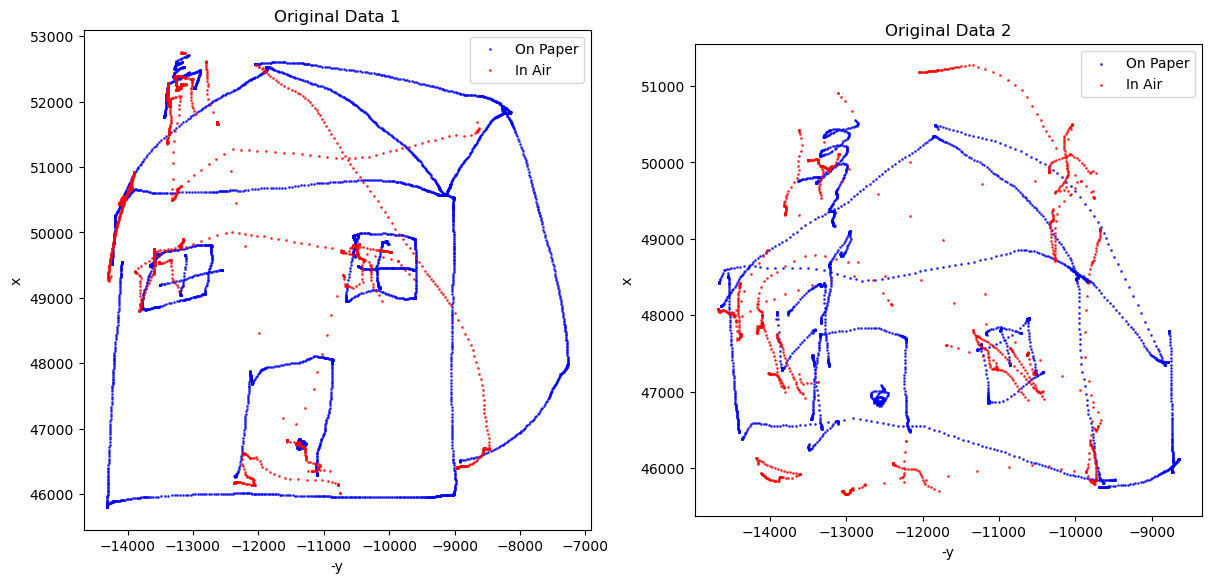

Augmented data saved to augmented_data\synthetic_u00001s00001_hw00002(4).svc
Augmented data saved to augmented_data_nested\u00001s00001_hw00002.svc
Shape of augmented data for u00001s00001_hw00002.svc: (5970, 7)
Augmented data saved to augmented_data\synthetic_u00002s00001_hw00002(1).svc
Augmented data saved to augmented_data_nested\u00002s00001_hw00002.svc
Shape of augmented data for u00002s00001_hw00002.svc: (3391, 7)
Completed augmentation iteration 2
Starting augmentation iteration 3


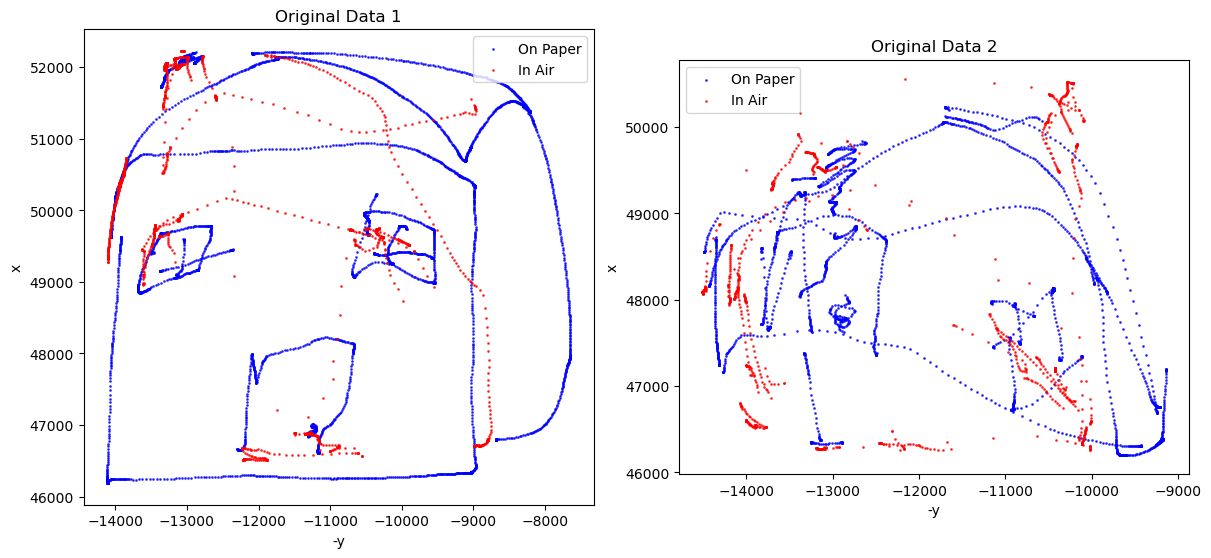

Augmented data saved to augmented_data\synthetic_u00001s00001_hw00002(5).svc
Augmented data saved to augmented_data_nested\u00001s00001_hw00002.svc
Shape of augmented data for u00001s00001_hw00002.svc: (5969, 7)
Augmented data saved to augmented_data\synthetic_u00002s00001_hw00002(2).svc
Augmented data saved to augmented_data_nested\u00002s00001_hw00002.svc
Shape of augmented data for u00002s00001_hw00002.svc: (3390, 7)
Completed augmentation iteration 3
Cleared augmented_data_nested directory after the final iteration.
Nested augmentation process completed.
No augmented data files found in the directory.


In [129]:
# Cell 10
import shutil

# Base latent variability settings
base_latent_variability = 100.0
latent_variability_range = (0.99, 1.01)
all_augmented_data = []  # Global list to store all augmented data

def repeat_backwards(original_paa, augmented_length):
    repeat_count = augmented_length - len(original_paa)
    if repeat_count <= 0:
        return original_paa
    backwards_rows = np.empty((0, original_paa.shape[1]))
    for i in range(repeat_count):
        row_to_repeat = original_paa[-(i % len(original_paa) + 1)]
        backwards_rows = np.vstack((backwards_rows, row_to_repeat))
    return np.vstack((original_paa, backwards_rows))

def visualize_augmented_data_from_directory(directory):
    augmented_files = [f for f in os.listdir(directory) if f.startswith('augmented_') and f.endswith('.svc')]
    num_files = len(augmented_files)
    if num_files == 0:
        print("No augmented data files found in the directory.")
        return
    
    fig, axs = plt.subplots(1, num_files, figsize=(6 * num_files, 6), constrained_layout=True)
    if num_files == 1:
        axs = [axs]
    
    for i, filename in enumerate(augmented_files):
        file_path = os.path.join(directory, filename)
        df = pd.read_csv(file_path, delim_whitespace=True, header=None)
        df.columns = ['x', 'y', 'timestamp', 'pen_status', 'pressure', 'azimuth', 'altitude']
        
        on_paper = df[df['pen_status'] == 1]
        in_air = df[df['pen_status'] == 0]

        axs[i].scatter(on_paper['y'], on_paper['x'], c='b', s=1, alpha=0.7, label='On Paper')
        axs[i].scatter(in_air['y'], in_air['x'], c='r', s=1, alpha=0.7, label='In Air')
        axs[i].set_title(f'Augmented Data {i + 1}')
        axs[i].set_xlabel('y')
        axs[i].set_ylabel('x')
        axs[i].invert_xaxis()
        axs[i].set_aspect('equal')
        axs[i].legend()
    
    plt.show()

def get_unique_filename(directory, filename):
    base, extension = os.path.splitext(filename)
    counter = 1
    while os.path.exists(os.path.join(directory, filename)):
        filename = f"{base}({counter}){extension}"
        counter += 1
    return filename

def download_augmented_data_with_modified_timestamp(augmented_datasets, scalers, original_data_frames, original_filenames, directory1='augmented_data', directory2='augmented_data_nested'):
    global all_augmented_data  # Access the global list

    if not os.path.exists(directory1):
        os.makedirs(directory1)
    
    if not os.path.exists(directory2):
        os.makedirs(directory2)

    for i, (augmented_data, scaler, original_df, original_filename) in enumerate(zip(augmented_datasets, scalers, original_data_frames, original_filenames)):
        augmented_xyz = scaler.inverse_transform(augmented_data[:, :3])
        augmented_xyz_int = np.rint(augmented_xyz).astype(int)
        pen_status = augmented_data[:, 3].astype(int)
        original_paa = original_df[['pressure', 'azimuth', 'altitude']].values
        
        if len(augmented_data) > len(original_paa):
            original_paa = repeat_backwards(original_paa, len(augmented_data))
        
        original_paa_int = np.rint(original_paa).astype(int)
        
        new_timestamps = np.zeros(len(augmented_data), dtype=int)
        increment_sequence = [7, 8]
        current_time = 0
        for idx in range(len(augmented_data)):
            new_timestamps[idx] = current_time
            current_time += increment_sequence[idx % 2]

        augmented_xyz_int[:, 2] = new_timestamps

        augmented_data_original_scale = np.column_stack((
            augmented_xyz_int,
            pen_status,
            original_paa_int[:len(augmented_data)]
        ))

        # Use the original filename for nested directory
        nested_filename = original_filename
        nested_file_path = os.path.join(directory2, nested_filename)

        # For augmented_data directory, add 'augmented_' prefix and handle duplicates
        augmented_filename = f"synthetic_{original_filename}"
        augmented_filename = get_unique_filename(directory1, augmented_filename)
        augmented_file_path = os.path.join(directory1, augmented_filename)

        np.savetxt(augmented_file_path, augmented_data_original_scale, fmt='%d', delimiter=' ')
        np.savetxt(nested_file_path, augmented_data_original_scale, fmt='%d', delimiter=' ')

        # Only store augmented data from the augmented_data directory
        all_augmented_data.append(augmented_data_original_scale)

        print(f"Augmented data saved to {augmented_file_path}")
        print(f"Augmented data saved to {nested_file_path}")
        print(f"Shape of augmented data for {original_filename}: {augmented_data_original_scale.shape}")

def nested_augmentation(num_augmentations, num_files_to_use):
    with custom_object_scope({'VAE': VAE}):
        vae_pretrained = load_model('vae_models/epoch_100_model.h5')
    print("Pretrained VAE model loaded.")

    # Use the existing data for the first iteration
    global data_frames, processed_data, scalers, avg_data_points, input_filenames, original_data_frames

    for iteration in range(num_augmentations):
        print(f"Starting augmentation iteration {iteration + 1}")
        
        if iteration > 0:
            # Only update the data for subsequent iterations
            directory = 'augmented_data_nested'
            data_frames, processed_data, scalers, avg_data_points, input_filenames, original_data_frames = upload_and_process_files(directory, num_files_to_use)
        
        augmented_datasets = generate_augmented_data(vae_pretrained, num_files_to_use, avg_data_points, processed_data, 
                                                     base_latent_variability, latent_variability_range)
        
        # Clear augmented_data_nested directory
        if os.path.exists('augmented_data_nested'):
            shutil.rmtree('augmented_data_nested')
        os.makedirs('augmented_data_nested')
        
        download_augmented_data_with_modified_timestamp(augmented_datasets, scalers, original_data_frames, input_filenames)
        
        print(f"Completed augmentation iteration {iteration + 1}")
    
    # Clear augmented_data_nested directory after the last iteration
    if os.path.exists('augmented_data_nested'):
        shutil.rmtree('augmented_data_nested')
        print("Cleared augmented_data_nested directory after the final iteration.")
    
    print("Nested augmentation process completed.")
    visualize_augmented_data_from_directory('augmented_data')
    

# Set the number of augmentations and files to use
num_augmentations = 3  # Change this to control the number of nested augmentations

# Run the nested augmentation process
nested_augmentation(num_augmentations, num_files_to_use)

In [99]:
# Cell 11 NRMSE
from glob import glob
import re

def read_svc_file(file_path):
    return pd.read_csv(file_path, sep=' ', header=None, 
                       names=['x', 'y', 'timestamp', 'pen_status', 'pressure', 'azimuth', 'altitude'])

def calculate_nrmse(original, predicted):
    if original.shape != predicted.shape:
        raise ValueError("The shapes of the original and predicted datasets must match.")
    mse = np.mean((original - predicted) ** 2)
    rmse = np.sqrt(mse)
    nrmse = rmse / (np.max(original) - np.min(original))
    return nrmse

def get_matching_augmented_files(original_file, augmented_folder):
    base_name = os.path.basename(original_file)
    base_name_without_ext = os.path.splitext(base_name)[0]
    pattern = os.path.join(augmented_folder, f"synthetic_{base_name_without_ext}*.svc")
    matching_files = glob(pattern)
    
    # Sort files based on the number in parentheses, with the base file (no number) first
    def sort_key(filename):
        match = re.search(r'\((\d+)\)', filename)
        return int(match.group(1)) if match else -1
    
    return sorted(matching_files, key=sort_key)

def process_files(imputed_folder, augmented_folder, input_filenames):
    nrmse_results = {}

    # Create a set of base filenames (without extensions) for easy comparison
    input_filenames_set = {os.path.splitext(os.path.basename(filename))[0] for filename in input_filenames}

    for original_file in glob(os.path.join(imputed_folder, "*.svc")):
        base_name = os.path.splitext(os.path.basename(original_file))[0]
        
        # Only process files that are present in input_filenames
        if base_name not in input_filenames_set:
            continue
        
        file_name = os.path.basename(original_file)
        original_data = read_svc_file(original_file)
        
        matching_augmented_files = get_matching_augmented_files(original_file, augmented_folder)
        
        file_nrmse = []
        for augmented_file in matching_augmented_files:
            augmented_data = read_svc_file(augmented_file)
            
            # Trim to the shorter length
            min_length = min(len(original_data), len(augmented_data))
            original_array = original_data.iloc[:min_length].values
            augmented_array = augmented_data.iloc[:min_length].values
            
            nrmse = calculate_nrmse(original_array, augmented_array)
            file_nrmse.append(nrmse)
        
        nrmse_results[file_name] = file_nrmse

    return nrmse_results

# Define the folders directly in the notebook cell
imputed_folder = "imputed"
augmented_folder = "augmented_data"

# Process the files and calculate NRMSE
results = process_files(imputed_folder, augmented_folder, input_filenames)

# Display the results
for original_file, nrmse_values in results.items():
    print(f"Results for {original_file}:")
    for i, nrmse in enumerate(nrmse_values):
        augmented_version = f"({i})" if i > 0 else "base"
        print(f"  NRMSE for augmented version {augmented_version}: {nrmse:.4f}")
    
    if nrmse_values:
        avg_nrmse = np.mean(nrmse_values)
        print(f"  Average NRMSE: {avg_nrmse:.4f}")
    print()

# Calculate and display the overall average NRMSE
all_nrmse = [nrmse for nrmse_list in results.values() for nrmse in nrmse_list]
overall_avg_nrmse = np.mean(all_nrmse)
print(f"Overall Average NRMSE: {overall_avg_nrmse:.4f}")

Results for u00001s00001_hw00003.svc:
  NRMSE for augmented version base: 0.0319
  NRMSE for augmented version (1): 0.0345
  NRMSE for augmented version (2): 0.0114
  NRMSE for augmented version (3): 0.0195
  Average NRMSE: 0.0243

Overall Average NRMSE: 0.0243


In [89]:
# Cell 12 Post-Hoc Discriminative Score
def process_files(imputed_folder, augmented_folder, input_filenames):
    all_real_data = []
    all_synthetic_data = []

    # Create a set of base filenames (without extensions) for easy comparison
    input_filenames_set = {os.path.splitext(os.path.basename(filename))[0] for filename in input_filenames}

    for original_file in glob(os.path.join(imputed_folder, "*.svc")):
        base_name = os.path.splitext(os.path.basename(original_file))[0]
        
        # Only process files that are present in input_filenames
        if base_name not in input_filenames_set:
            continue
        
        original_data = read_svc_file(original_file)
        all_real_data.append(original_data.values)
        
        matching_augmented_files = get_matching_augmented_files(original_file, augmented_folder)
        
        for augmented_file in matching_augmented_files:
            augmented_data = read_svc_file(augmented_file)
            all_synthetic_data.append(augmented_data.values)

    return np.concatenate(all_real_data), np.concatenate(all_synthetic_data)

def create_lstm_classifier(input_shape):
    model = Sequential([
        LSTM(64, input_shape=input_shape, return_sequences=True),
        LSTM(32),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

def prepare_data_for_lstm(real_data, synthetic_data):
    n_features = min(real_data.shape[1], synthetic_data.shape[1])
    real_data_trimmed = real_data[:, :n_features]
    synthetic_data_trimmed = synthetic_data[:, :n_features]
    
    X = np.vstack((real_data_trimmed, synthetic_data_trimmed))
    y = np.concatenate((np.ones(len(real_data)), np.zeros(len(synthetic_data))))
    return X, y

def post_hoc_discriminative_score(real_data, synthetic_data, n_splits=10):
    X, y = prepare_data_for_lstm(real_data, synthetic_data)
    
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    accuracies = []
    
    for fold, (train_index, test_index) in enumerate(kf.split(X)):
        print(f"\nFold {fold + 1}/{n_splits}:")  # New print statement for fold numbers
        
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
        X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

        model = create_lstm_classifier((1, X_train.shape[2]))
        
        # Train model and show epoch progress for this fold
        history = model.fit(X_train, y_train, epochs=2, batch_size=512, verbose=1)

        y_pred = (model.predict(X_test) > 0.5).astype(int)
        accuracy = accuracy_score(y_test, y_pred)
        accuracies.append(accuracy)

    mean_accuracy = np.mean(accuracies)
    std_accuracy = np.std(accuracies)
    return mean_accuracy, std_accuracy

# Specify your folders
imputed_folder = "imputed"
augmented_folder = "augmented_data"

# Process files, without NRMSE
real_data, synthetic_data = process_files(imputed_folder, augmented_folder, input_filenames)

# Compute post-hoc discriminative score
mean_accuracy, std_accuracy = post_hoc_discriminative_score(real_data, synthetic_data)

print(f"Mean accuracy: {mean_accuracy:.4f} (±{std_accuracy:.4f})")


Fold 1/10:


c:\Users\katod\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/2
17/17 ━━━━━━━━━━━━━━━━━━━━ 16s 70ms/step - accuracy: 0.5453 - loss: 0.6910
Epoch 2/2
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - accuracy: 0.6706 - loss: 0.6851
30/30 ━━━━━━━━━━━━━━━━━━━━ 6s 94ms/step

Fold 2/10:


c:\Users\katod\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/2
17/17 ━━━━━━━━━━━━━━━━━━━━ 15s 22ms/step - accuracy: 0.5053 - loss: 0.6928
Epoch 2/2
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - accuracy: 0.5723 - loss: 0.6900
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 39ms/step

Fold 3/10:
Epoch 1/2


c:\Users\katod\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


17/17 ━━━━━━━━━━━━━━━━━━━━ 13s 34ms/step - accuracy: 0.5148 - loss: 0.6945
Epoch 2/2
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.5482 - loss: 0.6874
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step

Fold 4/10:


c:\Users\katod\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/2
17/17 ━━━━━━━━━━━━━━━━━━━━ 10s 25ms/step - accuracy: 0.5309 - loss: 0.6918
Epoch 2/2
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.5679 - loss: 0.6857
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step

Fold 5/10:
Epoch 1/2


c:\Users\katod\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


17/17 ━━━━━━━━━━━━━━━━━━━━ 9s 24ms/step - accuracy: 0.5595 - loss: 0.6911
Epoch 2/2
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.6047 - loss: 0.6853
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step

Fold 6/10:


c:\Users\katod\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/2
17/17 ━━━━━━━━━━━━━━━━━━━━ 10s 23ms/step - accuracy: 0.5261 - loss: 0.6920
Epoch 2/2
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - accuracy: 0.5429 - loss: 0.6866
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 63ms/step

Fold 7/10:


c:\Users\katod\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/2
17/17 ━━━━━━━━━━━━━━━━━━━━ 10s 22ms/step - accuracy: 0.5221 - loss: 0.6918
Epoch 2/2
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - accuracy: 0.6208 - loss: 0.6835
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step

Fold 8/10:


c:\Users\katod\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/2
17/17 ━━━━━━━━━━━━━━━━━━━━ 11s 21ms/step - accuracy: 0.5949 - loss: 0.6893
Epoch 2/2
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.6307 - loss: 0.6787
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 52ms/step

Fold 9/10:


c:\Users\katod\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/2
17/17 ━━━━━━━━━━━━━━━━━━━━ 10s 22ms/step - accuracy: 0.5758 - loss: 0.6895
Epoch 2/2
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.6178 - loss: 0.6819
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step

Fold 10/10:


c:\Users\katod\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/2
17/17 ━━━━━━━━━━━━━━━━━━━━ 8s 22ms/step - accuracy: 0.5379 - loss: 0.6934
Epoch 2/2
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.5543 - loss: 0.6872
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step
Mean accuracy: 0.6324 (±0.0437)


In [90]:
# Cell 13 Post Hoc Predictive Score
import numpy as np
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.model_selection import KFold
from keras.callbacks import Callback
from tqdm import tqdm

# Step 1: Prepare Data
def prepare_data(df, time_steps=5):
    data = df[['x', 'y']].values
    scaler = MinMaxScaler(feature_range=(0, 1))
    data_scaled = scaler.fit_transform(data)
    
    # Create sequences of length `time_steps`
    X, y = [], []
    for i in range(len(data_scaled) - time_steps):
        X.append(data_scaled[i:i+time_steps])
        y.append(data_scaled[i+time_steps])
    
    return np.array(X), np.array(y), scaler

# Example usage
X, y, scaler = prepare_data(data_frames[0])

# Custom callback for progress bar
class CustomCallback(Callback):
    def on_train_begin(self, logs=None):
        self.epochs = self.params['epochs']
        self.progress_bar = tqdm(total=self.epochs, desc="Training Progress")

    def on_epoch_end(self, epoch, logs=None):
        self.progress_bar.update(1)

    def on_train_end(self, logs=None):
        self.progress_bar.close()

# Step 2: Define the LSTM Model
def create_model(input_shape):
    model = Sequential()
    model.add(LSTM(50, return_sequences=True, input_shape=input_shape))
    model.add(Dropout(0.2))  # Adding dropout to introduce randomness
    model.add(LSTM(50))
    model.add(Dropout(0.2))
    model.add(Dense(2))  # Predict x and y
    model.compile(optimizer='adam', loss='mse')
    return model

# Step 3: Evaluate Model Function
def evaluate_model(model, X_test, y_test, scaler):
    # Predict and inverse transform
    y_pred = model.predict(X_test)
    y_pred_rescaled = scaler.inverse_transform(y_pred)
    y_test_rescaled = scaler.inverse_transform(y_test)
    
    # Compute MAPE for each test sample
    mape = mean_absolute_percentage_error(y_test_rescaled, y_pred_rescaled)
    print(f"\nMAPE: {mape * 100:.2f}%")
    
    # Interpretation of MAPE
    if mape < 0.1:
        interpretation = "Excellent prediction"
    elif mape < 0.2:
        interpretation = "Good prediction"
    elif mape < 0.5:
        interpretation = "Fair prediction"
    else:
        interpretation = "Poor prediction"
    
    print(f"Interpretation: {interpretation}")
    
    return mape

# Step 4: K-Fold Cross-Validation Implementation
kf = KFold(n_splits=10, shuffle=True, random_state=np.random.randint(1000))  # 10-fold cross-validation

mape_values = []
for fold, (train_index, test_index) in enumerate(kf.split(X), start=1):
    print(f"\n--- Fold {fold} ---")
    
    # Split data into training and testing sets for this fold
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    model = create_model((X_train.shape[1], X_train.shape[2]))
    model.fit(X_train, y_train, epochs=5, batch_size=512, verbose=3, callbacks=[CustomCallback()])
    
    # Evaluate the model and store MAPE
    mape = evaluate_model(model, X_test, y_test, scaler)
    print(f"Fold {fold} MAPE: {mape * 100:.2f}%")  # Print MAPE for the current fold
    mape_values.append(mape)

# Step 5: Calculate Mean and Standard Deviation of MAPE
mean_mape = np.mean(mape_values)
std_mape = np.std(mape_values)

print(f"\nMean MAPE: {mean_mape * 100:.2f}%")
print(f"Standard Deviation of MAPE: {std_mape * 100:.2f}%")


--- Fold 1 ---


c:\Users\katod\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
Training Progress:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 1/5


Training Progress:  20%|██        | 1/5 [00:11<00:47, 11.93s/it]

Epoch 2/5


Training Progress:  40%|████      | 2/5 [00:13<00:16,  5.66s/it]

Epoch 3/5


Training Progress:  60%|██████    | 3/5 [00:14<00:07,  3.70s/it]

Epoch 4/5


Training Progress:  80%|████████  | 4/5 [00:16<00:02,  2.85s/it]

Epoch 5/5


Training Progress: 100%|██████████| 5/5 [00:17<00:00,  3.47s/it]


14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 97ms/step

MAPE: 5.96%
Interpretation: Excellent prediction
Fold 1 MAPE: 5.96%

--- Fold 2 ---


c:\Users\katod\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
Training Progress:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 1/5


Training Progress:  20%|██        | 1/5 [00:11<00:46, 11.67s/it]

Epoch 2/5


Training Progress:  40%|████      | 2/5 [00:13<00:18,  6.04s/it]

Epoch 3/5


Training Progress:  60%|██████    | 3/5 [00:14<00:07,  3.84s/it]

Epoch 4/5


Training Progress:  80%|████████  | 4/5 [00:16<00:03,  3.09s/it]

Epoch 5/5


Training Progress: 100%|██████████| 5/5 [00:18<00:00,  3.60s/it]


14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 78ms/step

MAPE: 5.75%
Interpretation: Excellent prediction
Fold 2 MAPE: 5.75%

--- Fold 3 ---


c:\Users\katod\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
Training Progress:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 1/5


Training Progress:  20%|██        | 1/5 [00:10<00:40, 10.21s/it]

Epoch 2/5


Training Progress:  40%|████      | 2/5 [00:11<00:14,  4.73s/it]

Epoch 3/5


Training Progress:  60%|██████    | 3/5 [00:11<00:05,  2.88s/it]

Epoch 4/5


Training Progress:  80%|████████  | 4/5 [00:12<00:02,  2.01s/it]

Epoch 5/5


Training Progress: 100%|██████████| 5/5 [00:13<00:00,  2.64s/it]


14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 69ms/step

MAPE: 2.84%
Interpretation: Excellent prediction
Fold 3 MAPE: 2.84%

--- Fold 4 ---


c:\Users\katod\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
Training Progress:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 1/5


Training Progress:  20%|██        | 1/5 [00:24<01:38, 24.70s/it]

Epoch 2/5


Training Progress:  40%|████      | 2/5 [00:26<00:34, 11.41s/it]

Epoch 3/5


Training Progress:  60%|██████    | 3/5 [00:28<00:14,  7.07s/it]

Epoch 4/5


Training Progress:  80%|████████  | 4/5 [00:30<00:04,  4.92s/it]

Epoch 5/5


Training Progress: 100%|██████████| 5/5 [00:32<00:00,  6.51s/it]


KeyboardInterrupt: 

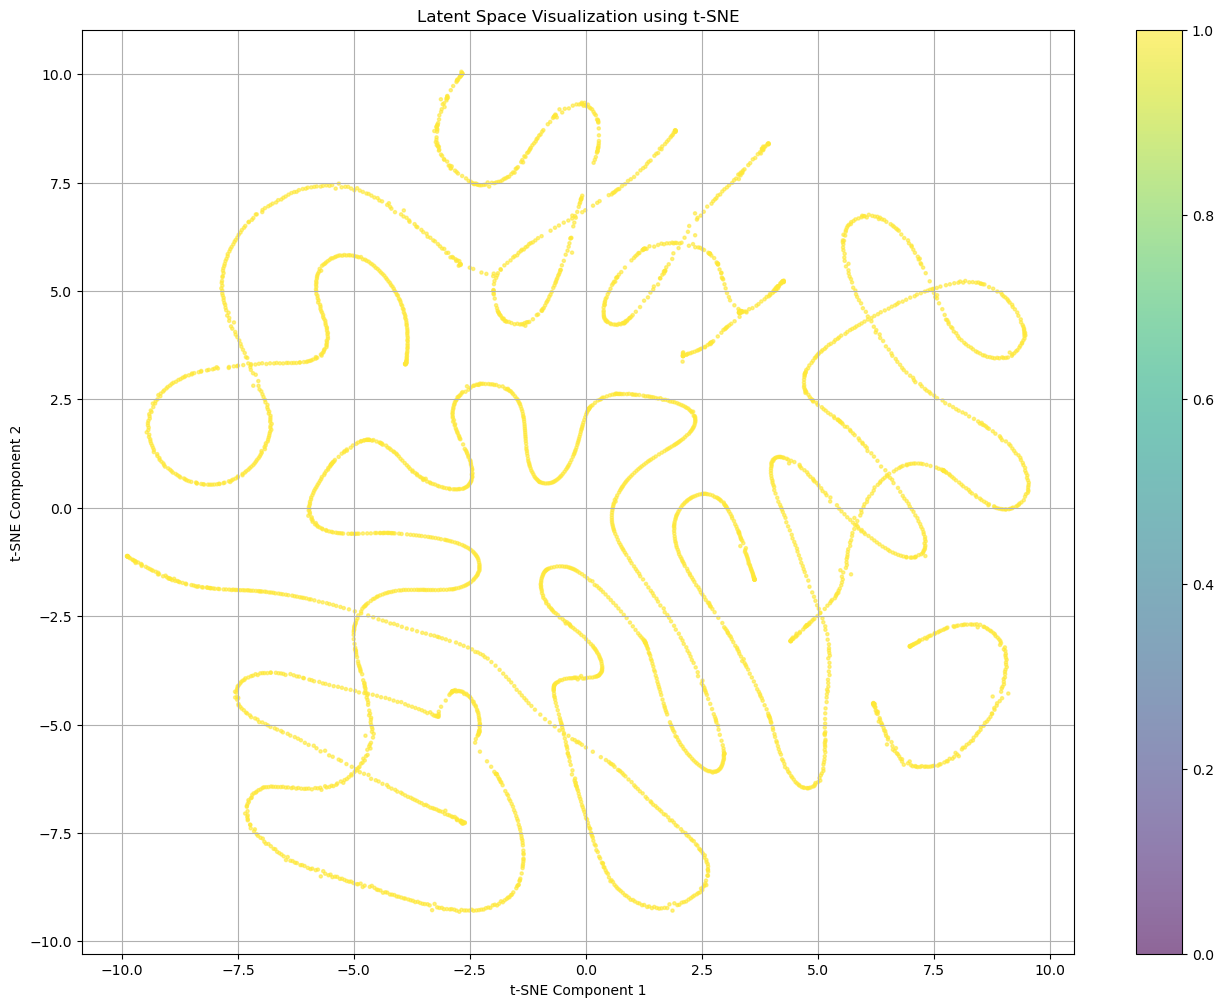

In [109]:
#Cell 13 Function to visualize the latent space with a color gradient
from sklearn.manifold import TSNE

def visualize_latent_space(model, data, perplexity=5, learning_rate=200, n_iter=250):
    # Encode data into the latent space
    latent_means, _ = model.encode(tf.convert_to_tensor(data, dtype=tf.float32))
    latent_means_np = latent_means.numpy()
    
    # Use t-SNE to reduce dimensionality to 2D
    tsne = TSNE(n_components=2, perplexity=perplexity, learning_rate=learning_rate, n_iter=n_iter)
    latent_2d = tsne.fit_transform(latent_means_np)
    
    # Create a color map for the latent points
    norm = plt.Normalize(vmin=np.min(latent_means_np), vmax=np.max(latent_means_np))
    cmap = plt.cm.cividis  # You can change the colormap to 'plasma', 'inferno', etc.
    colors = cmap(norm(latent_means_np).sum(axis=1))  # Coloring based on the sum of latent variables
    
    # Plot the 2D t-SNE result with the color map
    plt.figure(figsize=(16, 12))
    scatter = plt.scatter(latent_2d[:, 0], latent_2d[:, 1], c=colors, s=5, alpha=0.6)
    plt.colorbar(scatter)  # Add a color bar for the gradient
    plt.title('Latent Space Visualization using t-SNE')
    plt.xlabel('t-SNE Component 1')
    plt.ylabel('t-SNE Component 2')
    plt.grid(True)
    plt.show()

# Visualize latent space for one of the processed datasets
visualize_latent_space(vae, processed_data[0])

In [ ]:
# Cell 9 (modified to retain augmented data length)
def download_augmented_data_with_modified_timestamp(augmented_datasets, scalers, original_data_frames, original_filenames, directory='augmented_data'):
    if not os.path.exists(directory):
        os.makedirs(directory)

    for i, (augmented_data, scaler, original_df, original_filename) in enumerate(zip(augmented_datasets, scalers, original_data_frames, original_filenames)):
        # Inverse transform the augmented data
        augmented_xyz = scaler.inverse_transform(augmented_data[:, :3])
        
        # Round to integers
        augmented_xyz_int = np.rint(augmented_xyz).astype(int)
        
        # Get pen status from augmented data
        pen_status = augmented_data[:, 3].astype(int)
        
        # Prepare pressure, azimuth, altitude data
        original_paa = original_df[['pressure', 'azimuth', 'altitude']].values
        
        if len(augmented_data) > len(original_paa):
            original_paa = repeat_backwards(original_paa, len(augmented_data))
        
        # Round pressure, azimuth, altitude to integers
        original_paa_int = np.rint(original_paa).astype(int)
        
        # Generate new timestamps: start at 0, alternately incrementing by 7 and 8
        new_timestamps = np.zeros(len(augmented_data), dtype=int)
        increment_sequence = [7, 8]
        current_time = 0
        for idx in range(len(augmented_data)):
            new_timestamps[idx] = current_time
            current_time += increment_sequence[idx % 2]  # Alternate between 7 and 8

        # Replace the timestamp in the 3rd column of augmented_xyz_int
        augmented_xyz_int[:, 2] = new_timestamps

        # Combine all data: XYZ, pen status, pressure, azimuth, altitude
        augmented_data_original_scale = np.column_stack((
            augmented_xyz_int,
            pen_status,
            original_paa_int[:len(augmented_data)]
        ))

        # Construct the new file name to match the original file name
        augmented_filename = f"augmented_{original_filename}"
        augmented_file_path = os.path.join(directory, augmented_filename)

        # Save the augmented data to a file
        np.savetxt(augmented_file_path, augmented_data_original_scale, fmt='%d', delimiter=' ')

        print(f"Augmented data saved to {augmented_file_path}")
        print(f"Shape of augmented data for {original_filename}: {augmented_data_original_scale.shape}")

# Example call to the function
download_augmented_data_with_modified_timestamp(augmented_datasets, scalers, original_data_frames, input_filenames)

# Add this diagnostic print statement after generating augmented_datasets
print("Shapes of augmented datasets:")
for i, aug_data in enumerate(augmented_datasets):
    print(f"Shape of augmented dataset {i+1}: {aug_data.shape}")
